<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Analyse exploratoire </h1>

<h2 id="correct_data_format"> Importation des librairies </h2>

In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

In [27]:
#os.chdir("../../PredictionIncidentsCS/Data")
#pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 100)

<h2 id = ""> Importation des données </h2>

In [3]:
supervision = pd.read_csv("../../Data/Alertes/2019/all_data.csv", sep = ";")
tickets = pd.read_csv("../../Data/bdd_tickets.csv", sep = ";")

<h2 id = ""> Base supervision </h2>


La base supervision concerne toutes les alertes qui ont été créées. Elle contient 14 colones dont la colonne identifiant (ID).

Dans cette base, on peut y trouver des alertes pour lesquelles des tickets ont été créés et des alertes pour lesquelles des tickets n'ont pas été créés.
La colonne *Severity* indique le niveau de sévérité de l'alerte. Le statut de l'alerte peut être observé dans la colonne *Status*. L'heure de création de l'alerte (*Time created*) et l'heure de disparition de l'alerte indiquent respectivement les dates de création et de disparition de l'alerte, entre 2019 et 2020.

<h3 id = ""> Information sur le jeu de données </h3>

In [4]:
print("Les dimenssions du jeu de données: ", supervision.shape)
supervision.info()

Les dimenssions du jeu de données:  (1798556, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1798556 entries, 0 to 1798555
Data columns (total 16 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   ID           object
 1   Severity     int64 
 2   Status       object
 3   Time         object
 4   TimeCreated  object
 5   Message      object
 6   Events       int64 
 7   Count        int64 
 8   Subsystem    object
 9   HostName     object
 10  Source       object
 11  Origin       object
 12  Robot        object
 13  Probe        object
 14  Custom1      int64 
 15  Visible      object
dtypes: int64(4), object(12)
memory usage: 219.6+ MB


<h3 id = ""> Affichage des types des colonnes </h3>

In [5]:
supervision.dtypes

ID             object
Severity        int64
Status         object
Time           object
TimeCreated    object
Message        object
Events          int64
Count           int64
Subsystem      object
HostName       object
Source         object
Origin         object
Robot          object
Probe          object
Custom1         int64
Visible        object
dtype: object

Les colonnes 'Time' et 'TimeCreated' sont de type *object*. Il faut les convertir en date.

### Conversion des colonnes 'Time' et 'TimeCreated' et date

In [6]:
supervision['Time'] = pd.to_datetime(supervision['Time'])
supervision['TimeCreated'] = pd.to_datetime(supervision['TimeCreated'])

### Calcul de la durée entre l'apparition et la disparition d'une alerte

La durée ainsi calculée est stockée dans la colonne *duration*.

In [7]:
supervision['Duration'] = supervision['Time'] - supervision['TimeCreated']

On convertit la durée ainsi calculée en heure

In [8]:
supervision['Duration_h'] = 0.00
#supervision['Duration_m'] = 0.00
#supervision['Duration_s'] = 0.00
for i in range(len(supervision)):
    supervision['Duration_h'][i] = supervision['Duration'][i].total_seconds()/3600
    #supervision['Duration_m'][i] = supervision['Duration'][i].total_seconds()/60
    #supervision['Duration_s'][i] = supervision['Duration'][i].total_seconds()
    i += 1

/home/lild01.pictime.fr/loukouj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


On supprime maintenant la colonne *duration*. On gardera la colonne *duration_h* qui est dans un format plus simple.

In [9]:
supervision = supervision.drop('Duration', axis = 1)

On supprime à présent les lignes contenant de *NAs*.

En supprimant les NAs, on obtient une cassure dans les index de la table.

Par exemple la ligne d'index 80 ne se trouve plus dans notre table. C'est une ligne qui contenanait des Nas. Elle a donc été supprimée.

Il est donc important de re-indexer la table table.

In [10]:
supervision.dropna(inplace = True, axis = 0)
supervision = supervision.reset_index(drop=True)

In [127]:
tickets.head()

ID de la requete   Heure de creation Categorie   Priorite  \
0            280377 2015-06-11 18:22:00   Demande   3-Faible   
1            319699 2016-02-03 17:04:00  Probleme  2-Moyenne   
2            340448 2016-05-31 17:52:00   Demande  2-Moyenne   
3            342031 2016-06-07 18:24:00   Demande  2-Moyenne   
4            350047 2016-07-29 11:51:00   Demande   3-Faible   

                Groupe year_month  Heure    Weekday  
0  Direction Technique    2015-06     18   Thursday  
1                  SSE    2016-02     17  Wednesday  
2            Direction    2016-05     17    Tuesday  
3            Direction    2016-06     18    Tuesday  
4               EA PHP    2016-07     11     Friday

In [129]:
tickets['Categorie'].value_counts()

Evenement       30659
Demande         25993
Incident        13731
Notification    11760
Probleme         1856
Name: Categorie, dtype: int64

<h3 id = ""> Affichage des 5 dernières lignes </h3>

In [11]:
print("Les noms des colonnes:\n ", supervision.columns)
supervision.tail(5)

Les noms des colonnes:
  Index(['ID', 'Severity', 'Status', 'Time', 'TimeCreated', 'Message', 'Events',
       'Count', 'Subsystem', 'HostName', 'Source', 'Origin', 'Robot', 'Probe',
       'Custom1', 'Visible', 'Duration_h'],
      dtype='object')


ID  Severity  Status                Time  \
1795697  ZY80059480-71884         5  Closed 2019-09-30 09:56:27   
1795698  ZY80059480-71896         5  Closed 2019-09-30 09:56:55   
1795699  ZY80059480-71901         5  Closed 2019-09-30 09:56:55   
1795700  ZY80059480-71907         5  Closed 2019-09-30 09:57:06   
1795701  ZY80059480-71918         5  Closed 2019-09-30 09:57:21   

                TimeCreated  \
1795697 2019-09-30 09:56:22   
1795698 2019-09-30 09:56:26   
1795699 2019-09-30 09:56:52   
1795700 2019-09-30 09:56:58   
1795701 2019-09-30 09:57:03   

                                                   Message  Events  Count  \
1795697                                  ERROR smx : ERROR       3      3   
1795698  ERROR smx : ERROR : echec connexion ou nb bund...       1      1   
1795699                                  ERROR smx : ERROR       2      2   
1795700                                  ERROR smx : ERROR       1      1   
1795701  ERROR smx : ERROR : echec connexion ou nb bund...       1      1   

        Subsystem    HostName       Source Origin       Robot   Probe  \
1795697     Robot  kiaepsesb3  10.61.218.6  BEKOM  kiaepsesb3  logmon   
1795698     Robot  kiaepsesb3  10.61.218.6  BEKOM  kiaepsesb3  logmon   
1795699     Robot  kiaepsesb3  10.61.218.6  BEKOM  kiaepsesb3  logmon   
1795700     Robot  kiaepsesb3  10.61.218.6  BEKOM  kiaepsesb3  logmon   
1795701     Robot  kiaepsesb3  10.61.218.6  BEKOM  kiaepsesb3  logmon   

         Custom1 Visible  Duration_h  
1795697        0      No    0.001389  
1795698        0      No    0.008056  
1795699        0      No    0.000833  
1795700        0      No    0.002222  
1795701        0      No    0.005000

In [12]:
#supervision.drop(['Hour', 'Heure'], axis = 1, inplace = True)

In [12]:
print(len(supervision))

1795702


In [14]:
# Heure de création de l'alerte
supervision['Hour'] = pd.to_datetime(supervision['TimeCreated']).dt.to_period('H')
supervision['Heure'] = 0
# len(supervision)
for i in range(1795702):
    supervision.iloc[i, 18] = supervision.iloc[i, 17].hour
    

# Jour de création de l'alerte
supervision["weekday"] = supervision["TimeCreated"].dt.day_name()

# Supression de la colonne Hour
supervision = supervision.drop('Hour', axis = 1)


print(supervision.shape)
supervision.head()

(1795702, 19)


ID  Severity  Status                Time         TimeCreated  \
0  AA24819711-06708         5  Closed 2020-02-08 04:22:17 2020-02-08 04:22:16   
1  AA24819711-08295         5  Closed 2020-02-08 04:27:26 2020-02-08 04:22:24   
2  AA24819711-50527         4  Closed 2020-02-08 04:26:41 2020-02-08 04:24:43   
3  AA24819711-84108         5  Closed 2020-02-08 04:27:17 2020-02-08 04:27:16   
4  AA24819711-85701         5  Closed 2020-02-08 04:32:23 2020-02-08 04:27:23   

                                             Message  Events  Count Subsystem  \
0  URL response for https://api.coreye.fr (COREYE...       1      1     Alarm   
1  The SNMP Agent at '10.60.16.156' is not respon...       1      1   Network   
2  Packet Loss is above threshold limit! (profile...       1      1   Network   
3  URL response for https://api.coreye.fr (COREYE...       1      1     Alarm   
4  N3064-FR-PAR2-B101B-02 miss .1.3.6.1.4.1.9.9.3...       1      1   Network   

           HostName            Source Origin          Robot        Probe  \
0     superviz-app1        10.31.65.1   PAR1  superviz-app1       logmon   
1      10.60.16.156      10.60.16.156   PAR1  superviz-app1      snmpget   
2  N5548-FR-PAR2-01  N5548-FR-PAR2-01   PAR1  superviz-app1  net_connect   
3     superviz-app1        10.31.65.1   PAR1  superviz-app1       logmon   
4      10.60.16.154      10.60.16.154   PAR1  superviz-app1      snmpget   

   Custom1 Visible  Duration_h  Heure   weekday  
0        0      No    0.000278      4  Saturday  
1        0      No    0.083889      4  Saturday  
2        0      No    0.032778      4  Saturday  
3        0      No    0.000278      4  Saturday  
4        0      No    0.083333      4  Saturday

### Statistiques descriptives des colonnes

---
<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h2> Variables continues </h2>

In [13]:
supervision.describe()

Severity        Events         Count       Custom1    Duration_h
count  1.795702e+06  1.795702e+06  1.795702e+06  1.795702e+06  1.795702e+06
mean   4.695658e+00  3.145324e+00  3.142250e+00  2.234369e+03  2.840354e-01
std    9.783744e-01  1.355999e+02  1.353971e+02  3.539115e+04  1.069128e+01
min    1.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00 -5.845069e+02
25%    5.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00  5.000000e-03
50%    5.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00  5.555556e-03
75%    5.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00  1.722222e-02
max    5.000000e+00  5.754100e+04  5.755800e+04  5.739490e+05  2.622721e+03

<h3 id = ""> Matrice de corrélation </h3>

In [14]:
supervision.corr()

Severity    Events     Count   Custom1  Duration_h
Severity    1.000000  0.000351  0.000345 -0.001951   -0.004713
Events      0.000351  1.000000  0.999882  0.105156    0.788637
Count       0.000345  0.999882  1.000000  0.105019    0.790960
Custom1    -0.001951  0.105156  0.105019  1.000000    0.098246
Duration_h -0.004713  0.788637  0.790960  0.098246    1.000000

- Count et Event : 99.98%
- Count, Event et Duration_h : 80%

Les trois variables *Events, Count et Duration_h* sont fortement corrélées. Plus la fréquence d'apparition de l'alerte est élevée, plus l'alerte dure.

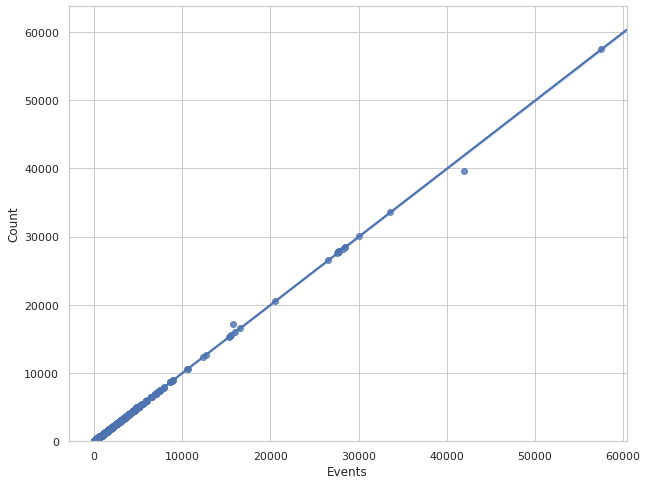

In [357]:
plt.figure(figsize = (10, 8))
sns.regplot(x="Events", y = "Count", data = supervision)
plt.ylim(0,)
plt.show()

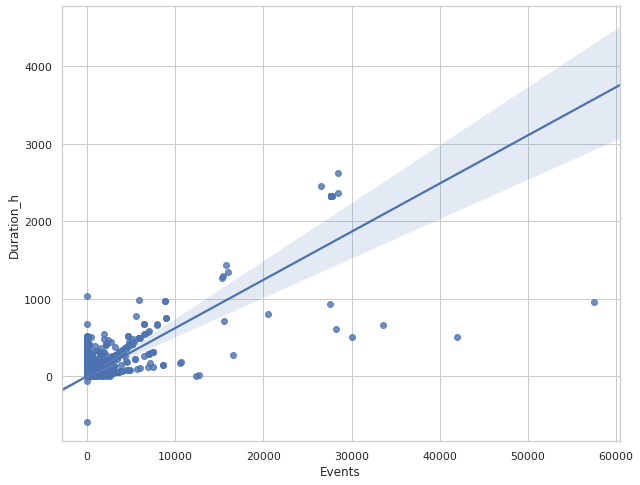

In [356]:
plt.figure(figsize = (10, 8))
sns.regplot(x="Events", y = "Duration_h", data = supervision)
plt.show()

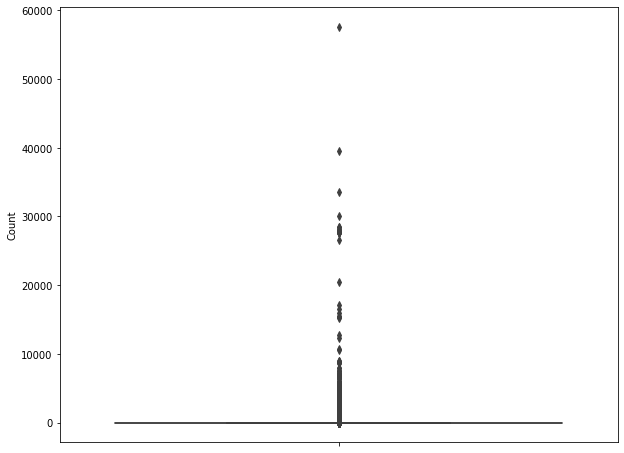

In [15]:
plt.figure(figsize = (10, 8))
sns.boxplot(y = supervision["Count"])
plt.show()

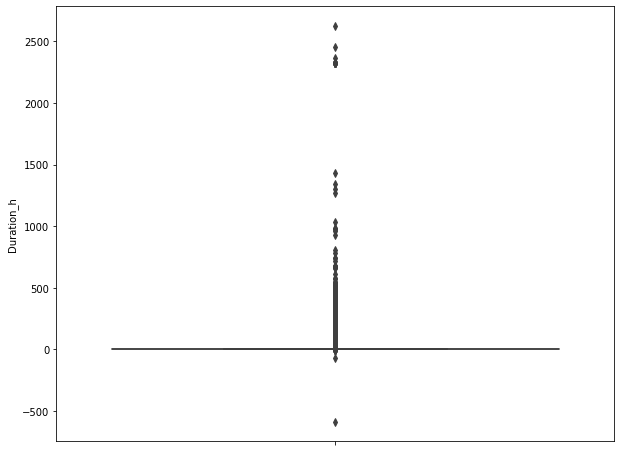

In [16]:
plt.figure(figsize = (10, 8))
sns.boxplot(y = supervision["Duration_h"])
plt.show()

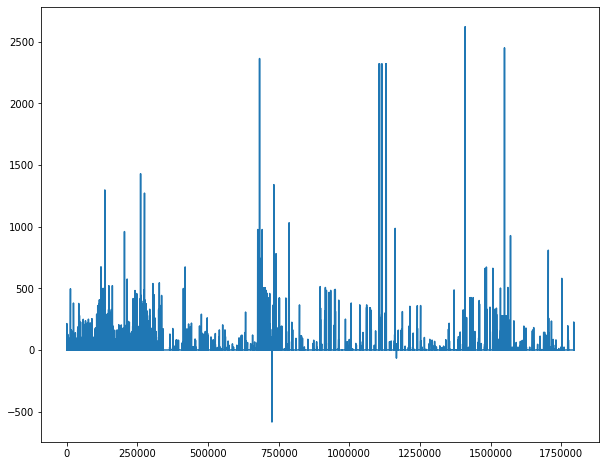

In [15]:
supervision['Duration_h'].plot(figsize=(10,8))

In [16]:
print(supervision[supervision['Time'] < supervision['TimeCreated']].shape)
print(supervision[supervision['Time'] < supervision['TimeCreated']][["Custom1", "Visible"]].describe(include = ["object"]))
supervision[supervision['Time'] < supervision['TimeCreated']].head(5)

(964, 17)
       Visible
count      964
unique       2
top         No
freq       960


ID  Severity  Status                Time  \
38331  IF78396410-00004         4  Closed 2020-02-12 15:09:28   
59112  BO49940653-00070         5  Closed 2020-02-22 11:07:14   
59116  BO49940653-00081         5  Closed 2020-02-22 11:07:14   
59117  BO49940653-00084         5  Closed 2020-02-22 11:07:14   
71744  NA27101380-02056         4  Closed 2020-02-22 17:00:21   

              TimeCreated                                            Message  \
38331 2020-02-12 15:09:48  Failed to send set_hub to spooler (communicati...   
59112 2020-02-22 11:08:08         consul_base: Process consul is not running   
59116 2020-02-22 11:08:08           swarm_base: Process swarm is not running   
59117 2020-02-22 11:08:08  registrator_base: Process registrator is not r...   
71744 2020-02-22 17:03:50  Memory - Pages per Second: Average value 2890....   

       Events  Count   Subsystem                HostName        Source  \
38331       1      1  Controller          srvapfr9350058  10.46.243.82   
59112       1      1     Process  cometik-prd-l-docker02   10.32.131.7   
59116       1      1     Process  cometik-prd-l-docker02   10.32.131.7   
59117       1      1     Process  cometik-prd-l-docker02   10.32.131.7   
71744       1      1    Exchange           unc-srv-exc01   46.17.67.44   

         Origin                   Robot             Probe  Custom1 Visible  \
38331  LABCOWEB          srvapfr9350058        controller        0      No   
59112   Cometik  cometik-prd-l-docker02         processes        0      No   
59116   Cometik  cometik-prd-l-docker02         processes        0      No   
59117   Cometik  cometik-prd-l-docker02         processes        0      No   
71744        SI           unc-srv-exc01  exchange_monitor        0      No   

       Duration_h  
38331   -0.005556  
59112   -0.015000  
59116   -0.015000  
59117   -0.015000  
71744   -0.058056

**Remarques:**

- Présence de quelques outliers
- Présence de durée négatives. Cela indique que certaines alertes ont été créées avant l'apparition de celles-ci, ce qui semble peu probable: 964 lignes concernées
- La durée maximale d'apparition d'une alerte est 109 jours

2020-02-18    382
2020-01-29    349
2020-02-19    128
2020-02-17     64
2020-01-30     16
2019-10-27      9
2020-02-22      6
2019-09-18      3
2019-10-29      2
2020-02-27      1
2020-02-12      1
2019-11-29      1
2019-10-24      1
2019-10-20      1
Freq: D, Name: TimeCreated, dtype: int64


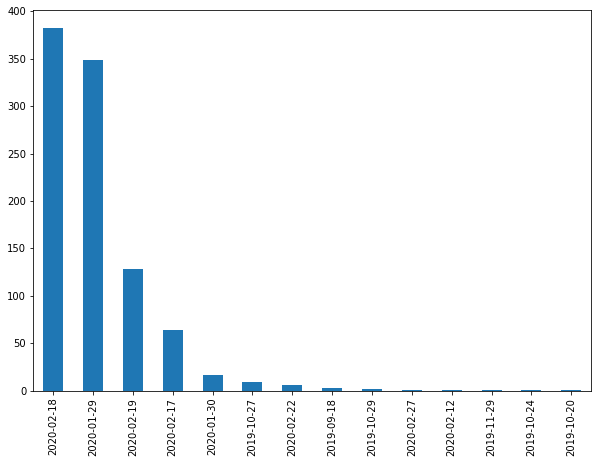

In [17]:
print(pd.to_datetime(supervision[supervision['Time'] < supervision['TimeCreated']]['TimeCreated']).dt.to_period('D').value_counts())
pd.to_datetime(supervision[supervision['Time'] < supervision['TimeCreated']]['TimeCreated']).dt.to_period('D').value_counts().plot.bar(figsize=(10,7))

- Seulement quelques jours (14) sont concernés par les durées négatives. Sur la période du 17 au 19 février, il s'agit de 574 alertes concernées sur 964, soit plus de la moitié.
- S'agissant du 29 janvier, 349 alertes sont concernées.
- Au total il s'agit donc pour la plupart d'incidents qui ont lieu début 2020.

Suppression des lignes concernées:

In [18]:
print("Dimension avant supression des lignes:\n", supervision.shape)
supervision = supervision[supervision['Time'] > supervision['TimeCreated']]
print("Dimension après supression des lignes:\n", supervision.shape)

Dimension avant supression des lignes:
 (1795702, 17)
Dimension après supression des lignes:
 (1793831, 17)


---
<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h2> Variables catégorielles </h2>

In [21]:
supervision.describe(include=['object'])

ID   Status                Message Subsystem  \
count            1793831  1793831                1793831   1793831   
unique           1793831        5                  34588        32   
top     KM67617306-71465   Closed  Cluster size not good     Alarm   
freq                   1  1691046                1246240   1494916   

                        HostName        Source      Origin  \
count                    1793831       1793831     1793831   
unique                      2964          2950         320   
top     codesrousseau-prd-l-db02  10.31.100.61  easysystem   
freq                      411934        411934     1207846   

                           Robot    Probe  Visible  
count                    1793831  1793831  1793831  
unique                      1662       37        2  
top     codesrousseau-prd-l-db02   logmon       No  
freq                      411934  1495917  1745742

<h3 id = ""> Analyse de la colonne 'Status' </h3>

In [19]:
print(supervision['Status'].value_counts().to_frame().shape)
supervision['Status'].value_counts().to_frame()

(5, 1)


Status
Closed      1691046
ClosedAuto    93739
ClosedBy       8969
Open             52
AssignedBy       25

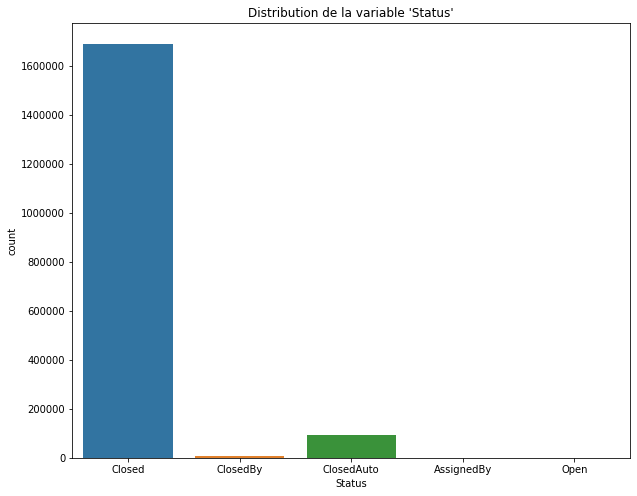

In [20]:
plt.figure(figsize = (10, 8))
sns.countplot(x = 'Status', data = supervision)
plt.title("Distribution de la variable 'Status'")
plt.show()

<h3 id = ""> Analyse de la colonne 'Message' </h3>

In [21]:
print(supervision['Message'].value_counts().to_frame().shape)
supervision['Message'].value_counts().to_frame().head(20)

(34588, 1)


Message
Cluster size not good                               1246240
Alerte KPI ne pas tenir compte                        93559
URL response for https://api.coreye.fr (COREYE)...    46535
Error AMQP operation was interrupted                  46528
Erreur AMQP operation was interrupted                 45046
Norauto production Script Sanity-Services.sh : ...    17983
Erreur sur la conformitÃ© des versions des cont...    16804
Queue 'alarmfromGaresRoutieres' failed to conne...    14627
Queue 'alarmfromapp7' failed to connect to hub ...    14475
Failed to send set_hub to spooler (communicatio...     8628
Norauto production Script Sanity-Services.sh : ...     7820
Norauto production Script Sanity-Filebeat.sh : ...     7818
Packet Loss is above threshold limit! (profile:...     6074
Packet Loss is above threshold limit! (profile:...     5883
docker registrator KO                                  5601
elasticsearch - error : curl: (28) Connection t...     4385
Robot rxfr-haproxy-2 is inactive                       4253
Filebeat Probe Status : error on server QP3SBOI...     3972
Robot clb-veeam-gw-2 is inactive                       3564
ERREUR - replication_postgresql : La difference...     3401

In [22]:
supervision['Message'].value_counts().to_frame().tail(20)

Message
URL response for 'secure_atlas'(ATLAS) : url ht...        1
planck: NTP server response time to 193.238.148...        1
Profile sqlserver, instance localhost, buffer c...        1
Enterprise (SNMP v2 Trap), SNMP v2 TRAP - 23665...        1
N5548-FR-PAR1-02, FR-PAR1-B212: The interface '...        1
Average (3 samples) system load is 3.54, which ...        1
URL response for 'EDEPOT-sla--gluster-be-fo03'(...        1
Average (3 samples) system load is 50.26, which...        1
Local file system /var/lib/docker/overlay2/13fc...        1
Average (3 samples) system load is 6.37, which ...        1
URL response for 'finadea.fr'(CGI) : url https:...        1
Profile sqlserver, instance localhost, buffer c...        1
Service - Microsoft Exchange Information Store:...        1
URL response for 'MRBRICOLAGE-mrbricolage.picti...        1
URL response for 'mrbricolage-checkout'(MRBRICO...        1
Average (2 samples) disk free on / is now 14%, ...        1
Average (3 samples) system load is 13.35, which...        1
URL response for 'EDF-edfinvest.com'(EDF) : url...        1
Average (3 samples) system load is 9.99, which ...        1
D_Archive_Temp: si fichiers de plus de 2 jours ...        1

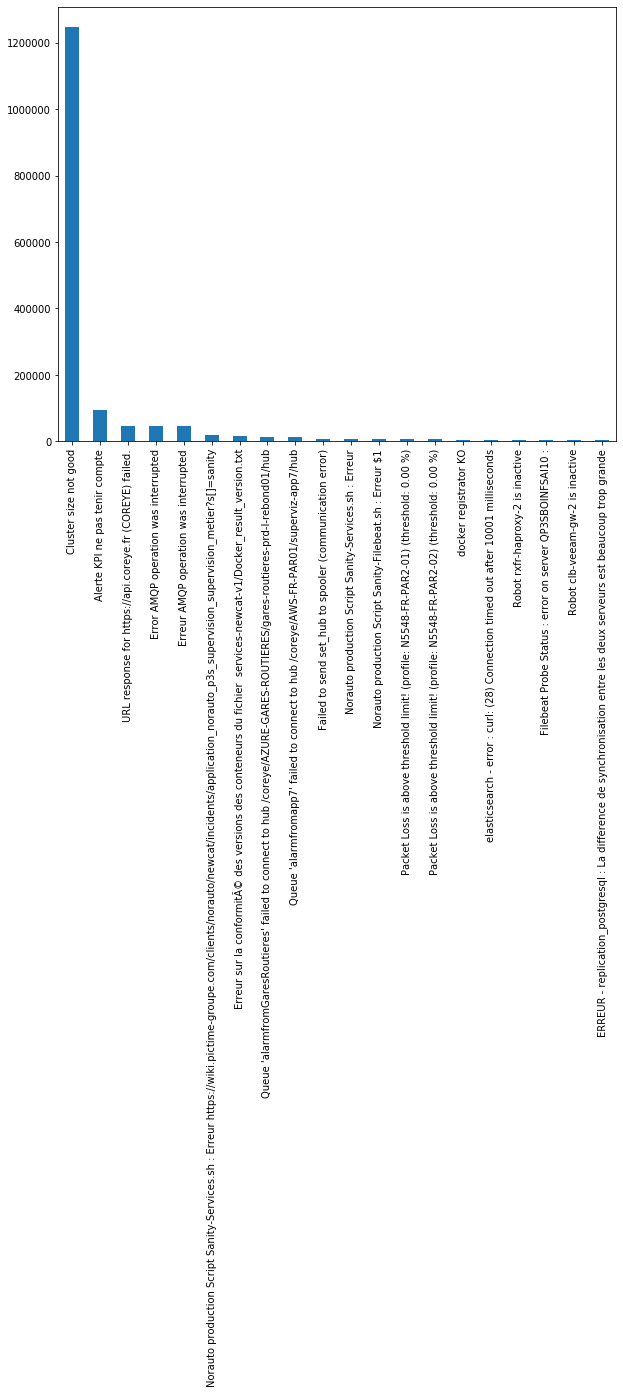

In [27]:
supervision['Message'].value_counts()[0:20].plot.bar(figsize=(10,8))

### Analyse de la colonne 'Subsystem'

In [23]:
print(supervision['Subsystem'].value_counts().to_frame().shape)
supervision['Subsystem'].value_counts().to_frame().head(5)

(32, 1)


Subsystem
Alarm                  1494916
Disk                     99737
Network                  59937
Application              41686
MessageDistribution      32007

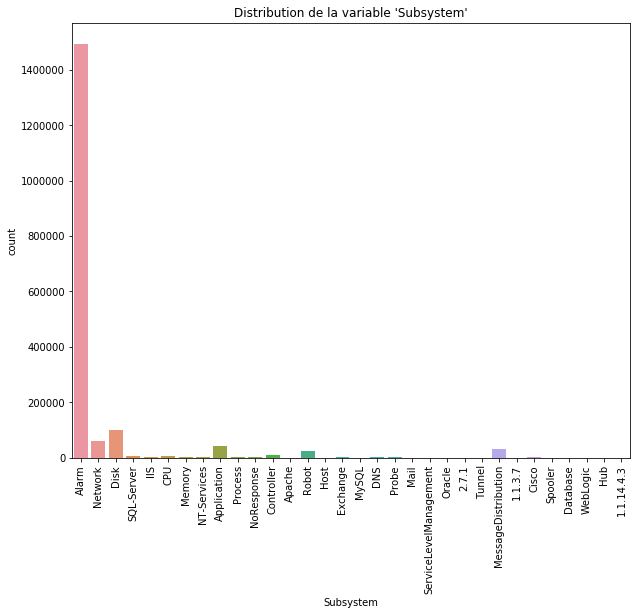

In [24]:
plt.figure(figsize = (10, 8))
sns.countplot(x = 'Subsystem', data = supervision)
plt.title("Distribution de la variable 'Subsystem'")
plt.xticks(rotation = 90)
plt.show()

### Analyse de la colonne 'HostName'

In [25]:
print(supervision['HostName'].value_counts().to_frame().shape)
supervision['HostName'].value_counts().to_frame().head(5)

(2964, 1)


HostName
codesrousseau-prd-l-db02    411934
codesrousseau-prd-l-db01    411888
codesrousseau-prd-l-db03    411706
superviz-app1                80529
superviz-bdd2                46898

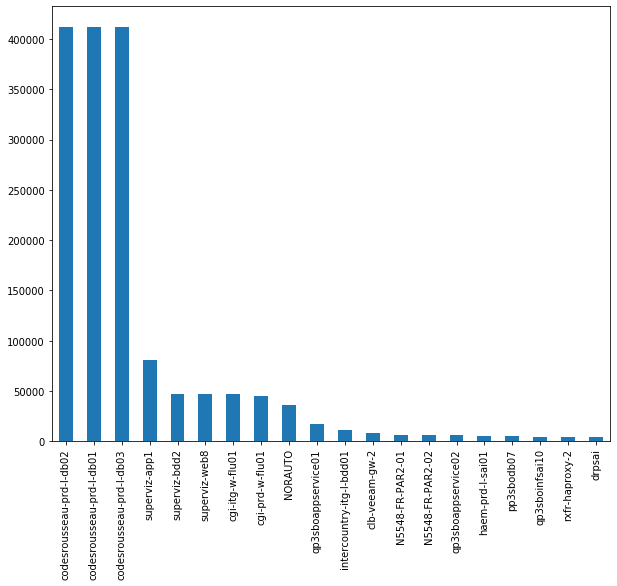

In [26]:
supervision['HostName'].value_counts()[0:20].plot.bar(figsize=(10,8))

### Analyse de la colonne 'Source'

In [27]:
print(supervision['Source'].value_counts().to_frame().shape)
supervision['Source'].value_counts().to_frame().head(5)

(2950, 1)


Source
10.31.100.61  411934
10.31.100.60  411888
10.31.100.62  411706
10.31.65.1     80514
10.41.64.1     46898

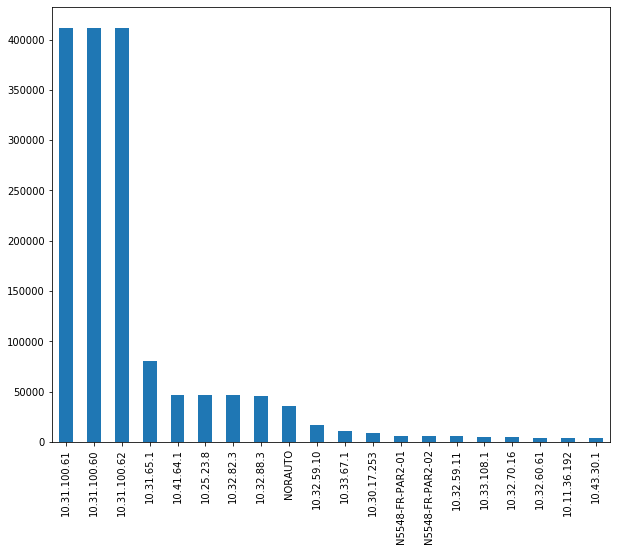

In [28]:
supervision['Source'].value_counts()[0:20].plot.bar(figsize=(10,8))

### Analyse de la colonne 'Origin'

In [29]:
print(supervision['Origin'].value_counts().to_frame().shape)
supervision['Origin'].value_counts().to_frame().head(5)

(320, 1)


Origin
easysystem  1207846
PAR1         152028
CGI           93708
NIMSOFT       87949
COREYE        59208

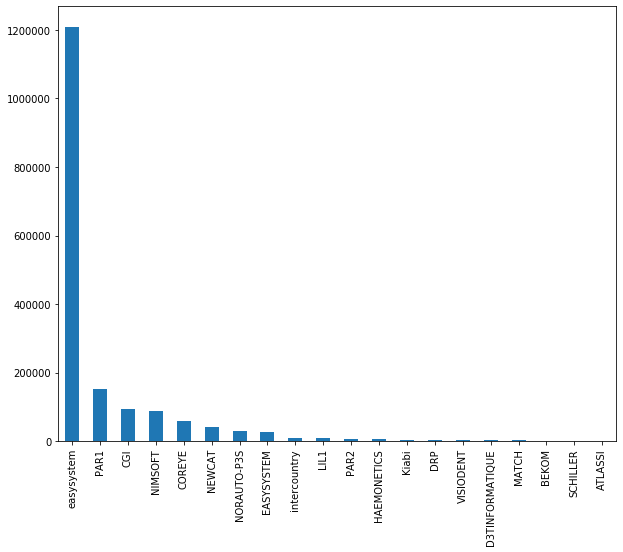

In [30]:
supervision['Origin'].value_counts()[0:20].plot.bar(figsize=(10,8))

In [31]:
print(supervision['Robot'].value_counts().to_frame().shape)
supervision['Robot'].value_counts().to_frame().head(5)

(1662, 1)


Robot
codesrousseau-prd-l-db02  411934
codesrousseau-prd-l-db01  411888
codesrousseau-prd-l-db03  411706
superviz-app1             139509
superviz-web8              47741

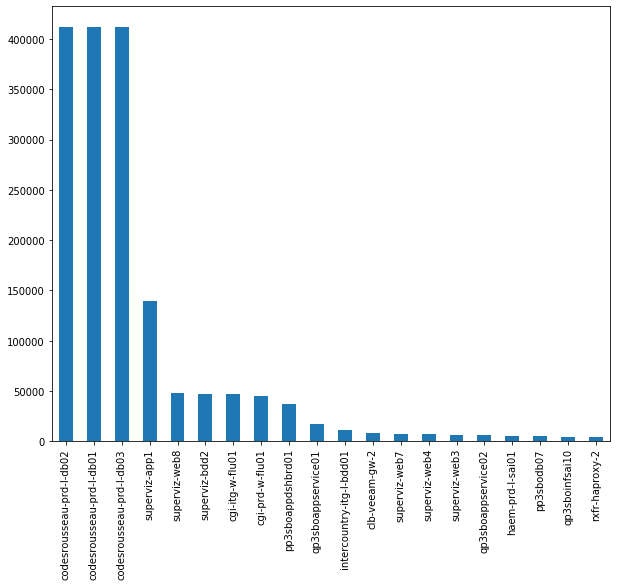

In [32]:
supervision['Robot'].value_counts()[0:20].plot.bar(figsize=(10,8))

In [33]:
print(supervision['Probe'].value_counts().to_frame().shape)
supervision['Probe'].value_counts().to_frame().head(5)

(37, 1)


Probe
logmon        1495917
cdm            109424
hub             54226
url_response    41564
snmpget         30796

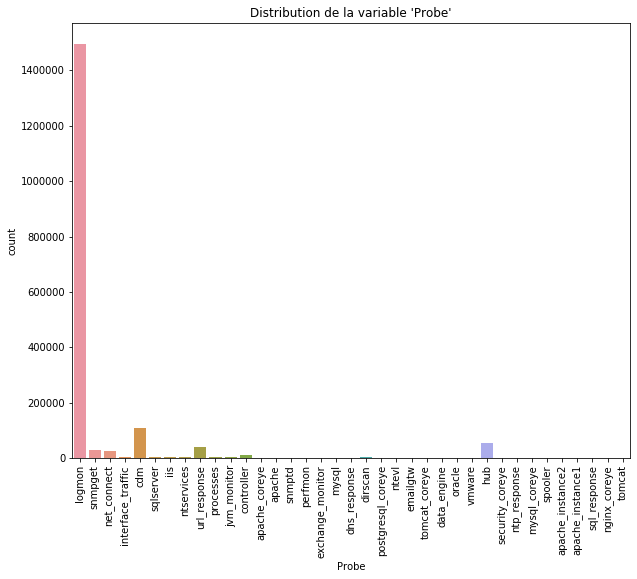

In [39]:
plt.figure(figsize = (10, 8))
sns.countplot(x = 'Probe', data = supervision)
plt.title("Distribution de la variable 'Probe'")
plt.xticks(rotation = 90)
plt.show()

### Analyse de la colonne 'Visible'

In [34]:
print(supervision['Visible'].value_counts().to_frame().shape)
supervision['Visible'].value_counts().to_frame()

(2, 1)


Visible
No   1745742
Yes    48089

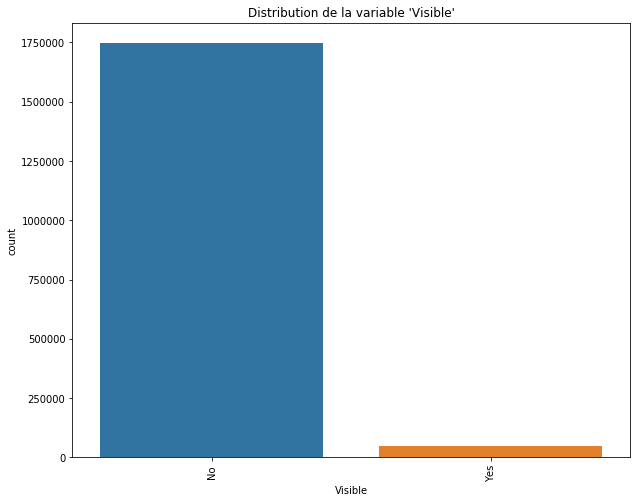

In [35]:
plt.figure(figsize = (10, 8))
sns.countplot(x = 'Visible', data = supervision)
plt.title("Distribution de la variable 'Visible'")
plt.xticks(rotation = 90)
plt.show()

### Analyse de la colonne 'Custom1'

- A présent, on considère les alertes pour lesquelles des tickets ont été créés
- L'objectif ici est d'arriver à apréhender le nombre élevé de doublons

In [36]:
count_custom1 = supervision['Custom1'].value_counts()
tickets_cree = sum(count_custom1.drop(index = 0))
print("Le nombre de tickets créés dans la table supervision :", tickets_cree)

Le nombre de tickets créés dans la table supervision : 7130


In [37]:
data_sup_tick = supervision.iloc[np.where(supervision['Custom1'] !=0)[0]]

data_sup_tick['TimeCreated']= pd.to_datetime(data_sup_tick['TimeCreated'])
data_sup_tick['Time']= pd.to_datetime(data_sup_tick['Time'])

print("On prend que les alertes où on a créé un ticket")
print(data_sup_tick.shape)
data_sup_tick.head(5)


On prend que les alertes où on a créé un ticket
(7130, 17)


/home/lild01.pictime.fr/loukouj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/lild01.pictime.fr/loukouj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


ID  Severity    Status                Time  \
30   AB92454454-80315         4    Closed 2020-02-10 13:58:05   
94   AE10920558-64042         5    Closed 2020-02-01 09:53:05   
95   AE10920558-77807         4    Closed 2020-02-10 08:03:06   
244  AJ95383449-49307         5    Closed 2020-02-01 09:10:34   
249  AK28657263-25096         5  ClosedBy 2020-02-06 19:06:53   

            TimeCreated                                            Message  \
30  2020-02-04 16:18:01  Average (2 samples) disk free on E:\ is now 10...   
94  2020-02-01 05:04:22  Average (2 samples) disk free on D:\ is now 2%...   
95  2020-02-01 09:58:00  Average (2 samples) disk free on D:\ is now 6%...   
244 2020-02-01 05:13:08  Average (3 samples) system load is 784.73, whi...   
249 2020-02-06 14:56:02  The interface 'Ethernet122/1/5' , description ...   

     Events  Count Subsystem                HostName                  Source  \
30     1630   1628      Disk               coruscant          91.195.164.181   
94       59     58      Disk                 mmapp02              10.43.36.2   
95     2139   2137      Disk                 mmapp02              10.43.36.2   
244      46     45       CPU  cometik-prd-l-docker01             10.32.131.6   
249      49     48   Network  N93180-FR-PAR1-B112-02  N93180-FR-PAR1-B112-02   

         Origin                   Robot              Probe  Custom1 Visible  \
30   CARTERCASH               coruscant                cdm   570452     Yes   
94          MMA                 mmapp02                cdm   570025     Yes   
95          MMA                 mmapp02                cdm   570060     Yes   
244     Cometik  cometik-prd-l-docker01                cdm   570027     Yes   
249        PAR1           superviz-app1  interface_traffic   570781     Yes   

     Duration_h  
30   141.667778  
94     4.811944  
95   214.085000  
244    3.957222  
249    4.180833

Quelques statistiques descriptives sur la table des tickets:

In [38]:
data_sup_tick.describe()

Severity        Events         Count        Custom1   Duration_h
count  7130.000000   7130.000000   7130.000000    7130.000000  7130.000000
mean      4.665498    229.577980    228.941374  562729.315147    16.967525
std       0.537187   1139.827678   1142.889127    6743.353692    56.201340
min       1.000000      2.000000      1.000000  506232.000000     0.030556
25%       4.000000      9.000000      8.000000  556694.000000     0.624444
50%       5.000000     25.000000     24.000000  563562.000000     2.205278
75%       5.000000    113.000000    112.000000  568286.000000     7.990278
max       5.000000  57541.000000  57558.000000  573949.000000  1430.020278

In [45]:
data_sup_tick.describe(include = ['object'])

ID  Status  \
count               7130    7130   
unique              7130       4   
top     YX46979854-62199  Closed   
freq                   1    5177   

                                                  Message    Subsystem  \
count                                                7130         7130   
unique                                               4432           25   
top     Trend - Une erreur est survenur durant la mise...  Application   
freq                                                   61         1729   

       HostName Source   Origin          Robot Probe Visible  
count      7130   7130     7130           7130  7130    7130  
unique     1195   1195      231            786    33       1  
top       KIABI  KIABI  NIMSOFT  superviz-app1   cdm     Yes  
freq        271    271     1644            842  2161    7130

- La durée moyenne entre l'apparition et la disparition d'une alerte ici est de: 17h,
- Avec une fréquence moyenne de: 230,
- La source la plus fréquente est *KIABI*, avec 271 tickets générés,
- 100% des alertes ayant généré un ticket sont visibles

In [41]:
count_custom1_id = data_sup_tick['Custom1'].value_counts()
print("On affiche toutes les valeurs unique de custom1\n", count_custom1_id)

On affiche toutes les valeurs unique de custom1
 569844    448
552908    172
561451     56
572401     56
554858     51
         ... 
564032      1
570899      1
565447      1
555338      1
552946      1
Name: Custom1, Length: 2826, dtype: int64


In [42]:
data_custo1_1 = data_sup_tick.iloc[np.where(data_sup_tick['Custom1'] == 569844)[0]]
data_custo1_1

ID  Severity    Status                Time  \
191840  EH38578397-29822         5  ClosedBy 2020-01-30 13:51:48   
191841  EH38578397-29825         5  ClosedBy 2020-01-30 13:51:48   
191842  EH38578397-29828         5  ClosedBy 2020-01-30 13:51:48   
191843  EH38578397-29895         5  ClosedBy 2020-01-30 14:21:20   
191844  EH38578397-29896         5  ClosedBy 2020-01-30 14:21:20   
...                  ...       ...       ...                 ...   
202803  ZN67990651-71127         5    Closed 2020-01-30 13:34:48   
202804  ZN67990651-71163         5    Closed 2020-01-30 13:34:48   
202805  ZN67990651-71167         5    Closed 2020-01-30 13:34:48   
202806  ZN67990651-71183         5    Closed 2020-01-30 13:34:48   
202807  ZN67990651-71199         5    Closed 2020-01-30 13:34:48   

               TimeCreated                                            Message  \
191840 2020-01-30 06:51:00      api-fr-ecatalog_base: Process  is not running   
191841 2020-01-30 06:51:00                  customer: Process  is not running   
191842 2020-01-30 06:51:00           apis-fr-content: Process  is not running   
191843 2020-01-30 06:55:07  The resource Microservice Order FR is not resp...   
191844 2020-01-30 06:55:07  The resource Microservice Customer FR is not r...   
...                    ...                                                ...   
202803 2020-01-30 09:14:04  es-messaging: Process *es/emessaging* is not r...   
202804 2020-01-30 09:14:04  apis-es-epartner: Process *es/epartner* is not...   
202805 2020-01-30 09:14:04  apis-es-erecommendation: Process *es/erecommen...   
202806 2020-01-30 09:14:04  apis-es-einventory: Process *es/einventory* is...   
202807 2020-01-30 09:14:04  apis_es_front_einventoryintegration: Process *...   

        Events  Count   Subsystem                  HostName  \
191840      44     43     Process                 kiaepptc3   
191841      44     43     Process                 kiaepptc3   
191842      44     43     Process                 kiaepptc3   
191843      90     89  NoResponse     Microservice Order FR   
191844      90     89  NoResponse  Microservice Customer FR   
...        ...    ...         ...                       ...   
202803      28     27     Process                 kiaepptc2   
202804      28     27     Process                 kiaepptc2   
202805      28     27     Process                 kiaepptc2   
202806      28     27     Process                 kiaepptc2   
202807      28     27     Process                 kiaepptc2   

                          Source       Origin      Robot        Probe  \
191840               46.17.64.52  KIABI-BEKOM  kiaepptc3    processes   
191841               46.17.64.52  KIABI-BEKOM  kiaepptc3    processes   
191842               46.17.64.52  KIABI-BEKOM  kiaepptc3    processes   
191843     Microservice Order FR  KIABI-BEKOM  kiaepptc3  jvm_monitor   
191844  Microservice Customer FR  KIABI-BEKOM  kiaepptc3  jvm_monitor   
...                          ...          ...        ...          ...   
202803              10.61.223.41  KIABI-BEKOM  kiaepptc2    processes   
202804              10.61.223.41  KIABI-BEKOM  kiaepptc2    processes   
202805              10.61.223.41  KIABI-BEKOM  kiaepptc2    processes   
202806              10.61.223.41  KIABI-BEKOM  kiaepptc2    processes   
202807              10.61.223.41  KIABI-BEKOM  kiaepptc2    processes   

        Custom1 Visible  Duration_h  
191840   569844     Yes    7.013333  
191841   569844     Yes    7.013333  
191842   569844     Yes    7.013333  
191843   569844     Yes    7.436944  
191844   569844     Yes    7.436944  
...         ...     ...         ...  
202803   569844     Yes    4.345556  
202804   569844     Yes    4.345556  
202805   569844     Yes    4.345556  
202806   569844     Yes    4.345556  
202807   569844     Yes    4.345556  

[448 rows x 17 columns]

**La table ci-dessus représente des alertes pour lesquelles le même numéro de ticket a été créé (448).**

- 448 alertes avec le même numéro de ticket (56844)
- Ces alertes ont été créées le même jour: 2020-01-30. Les heures de création, elles restent différentes.
- Les alertes proviennent du même client: KIABI

---
<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h2> Analyse bivariée et multivariée - regroupement</h2>

<h3 id = ""> Alertes pour lesquelles la fréquence est supérieure à 20000 </h3>

In [15]:
print(supervision[supervision['Count'] > 20000].shape)
supervision[supervision['Count'] > 20000].head(5)

(26, 19)


ID  Severity    Status                Time  \
128492   RN76593788-73984         5  ClosedBy 2020-01-23 08:58:43   
204051   BN11773784-77444         5  ClosedBy 2020-01-13 11:40:37   
682273   OF93512909-64593         5  ClosedBy 2020-02-26 10:29:53   
1105873  GJ68320594-30932         5  ClosedBy 2020-01-23 10:19:35   
1105874  GJ68320594-30933         5  ClosedBy 2020-01-23 10:19:35   

                TimeCreated  \
128492  2020-01-02 12:48:05   
204051  2019-12-04 11:03:08   
682273  2019-11-19 21:59:11   
1105873 2019-10-18 16:03:41   
1105874 2019-10-18 16:05:37   

                                                   Message  Events  Count  \
128492                       Robot pg04-prodco is inactive   42003  39603   
204051   Uptime HP 1810-48P : uptime is greater than 16...   57541  57558   
682273   Local file system /tank/docker/overlay2/3c646d...   28460  28461   
1105873  Can not start logmon, start after probe in err...   27712  27750   
1105874  Probe 'spooler' FAILED to start, file check de...   27715  27759   

          Subsystem               HostName                 Source      Origin  \
128492        Robot            pg04-prodco            10.32.122.5        LIL1   
204051      Network  C1810-FR-LIL1-B342-01  C1810-FR-LIL1-B342-01        PAR1   
682273         Disk   doctolib-l-prd-kvm07            10.32.124.7  ?NOORIGIN?   
1105873  Controller          hyp09-infraco            10.32.124.9    DOCTOLIB   
1105874  Controller          hyp09-infraco            10.32.124.9    DOCTOLIB   

                        Robot       Probe  Custom1 Visible   Duration_h  \
128492            pg04-prodco         hub        0      No   500.177222   
204051          superviz-app1     snmpget   562784     Yes   960.624722   
682273   doctolib-l-prd-kvm07         cdm        0      No  2364.511667   
1105873         hyp09-infraco  controller        0      No  2322.265000   
1105874         hyp09-infraco  controller        0      No  2322.232778   

         Heure    weekday  
128492      12   Thursday  
204051      11  Wednesday  
682273      21    Tuesday  
1105873     16     Friday  
1105874     16     Friday

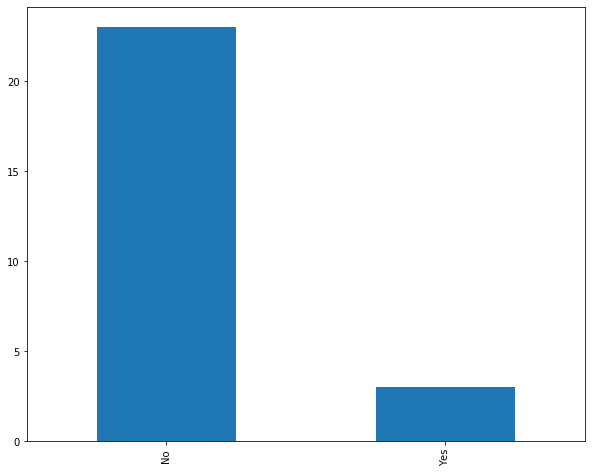

In [49]:
supervision[supervision['Count'] > 20000]['Visible'].value_counts().plot.bar(figsize=(10,8))

In [439]:
#supervision[supervision['Severity'] < 5].shape

### Analyse bivariée : *Visible* X *Status*

Visible        No     Yes
Status                   
AssignedBy   0.00  100.00
Closed      97.64    2.36
ClosedAuto  99.99    0.01
ClosedBy     9.61   90.39
Open        76.92   23.08


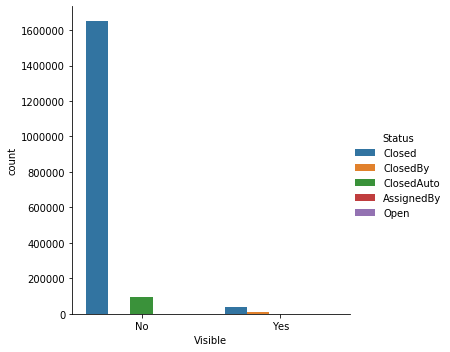

In [50]:
print(pd.crosstab(supervision.Status, supervision.Visible, normalize = 'index').round(4)*100)
sns.catplot(x = "Visible", hue = "Status", kind = "count", data = supervision) #, hue="class" x = "Categorie", 

- 100% des alertes avec un *Status Assigned by* sont visbles,
- Seulement 1% des alertes avec pour *Status Closed et Closed auto* sont visibles,
- 9.61% des alertes fermées par quesqu'un ne sont pas visibles (?),
- 8% des alertes avec un *Status Open* sont visibles

### Transformation de Custom1 (numéro ticket) en binaire

In [17]:
supervision = supervision.reset_index(drop=True)

In [18]:
for i in range(len(supervision)):
    if supervision.loc[i, 'Custom1'] != 0:
        supervision.loc[i, 'Custom1'] = 1
    i += 1

### Analyse bivariée Custom1 X Status

Custom1          0      1
Status                   
AssignedBy    8.00  92.00
Closed       99.69   0.31
ClosedAuto  100.00   0.00
ClosedBy     78.50  21.50
Open        100.00   0.00


<Figure size 720x576 with 0 Axes>

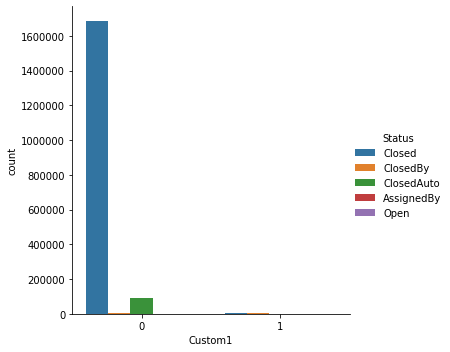

In [53]:
print(pd.crosstab(supervision.Status, supervision.Custom1, normalize = 'index').round(4)*100)
plt.figure(figsize = (10, 8))
sns.catplot(x = "Custom1", hue = "Status", kind = "count", data = supervision) #, hue="class" x = "Categorie", 
plt.show()

### Analyse bivariée Custom1 X Visible

Custom1       0      1
Visible               
No       100.00   0.00
Yes       85.17  14.83


<Figure size 720x576 with 0 Axes>

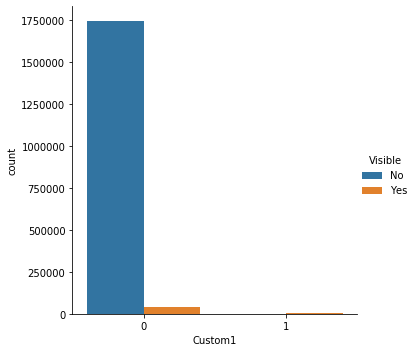

In [54]:
print(pd.crosstab(supervision.Visible, supervision.Custom1, normalize = 'index').round(4)*100)
plt.figure(figsize = (10, 8))
sns.catplot(x = "Custom1", hue = "Visible", kind = "count", data = supervision) #, hue="class" x = "Categorie", 
plt.show()

Seulement 15% des alertes visibles font l'objet de création de ticket

100% des alertes non visibles ne génère pas de ticket

### Analyse bivariéé : Custom1 X Severity

Custom1        0     1
Severity              
1         100.00  0.00
2          99.82  0.18
3          96.67  3.33
4          96.66  3.34
5          99.69  0.31


<Figure size 720x576 with 0 Axes>

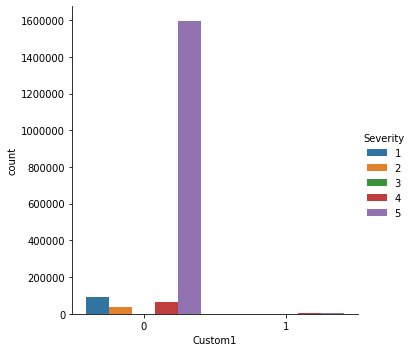

In [55]:
print(pd.crosstab(supervision.Severity, supervision.Custom1, normalize = 'index').round(4)*100)
plt.figure(figsize = (10, 8))
sns.catplot(x = "Custom1", hue = "Severity", kind = "count", data = supervision) #, hue="class" x = "Categorie", 
plt.show()

### Analyse bivariée : Custom1 X Subsystem

Custom1                      0      1
Subsystem                            
1.1.14.4.3              100.00   0.00
1.1.3.7                  99.13   0.87
2.7.1                   100.00   0.00
Alarm                    99.94   0.06
Apache                   93.44   6.56
Application              95.85   4.15
CPU                      92.67   7.33
Cisco                    99.85   0.15
Controller               98.91   1.09
DNS                      99.90   0.10
Database                100.00   0.00
Disk                     98.76   1.24
Exchange                 97.82   2.18
Host                     97.28   2.72
Hub                     100.00   0.00
IIS                      97.58   2.42
Mail                    100.00   0.00
Memory                   83.14  16.86
MessageDistribution      99.98   0.02
MySQL                    87.53  12.47
NT-Services              96.37   3.63
Network                  98.69   1.31
NoResponse               94.92   5.08
Oracle                   92.22   7.78
Probe       

<Figure size 1080x576 with 0 Axes>

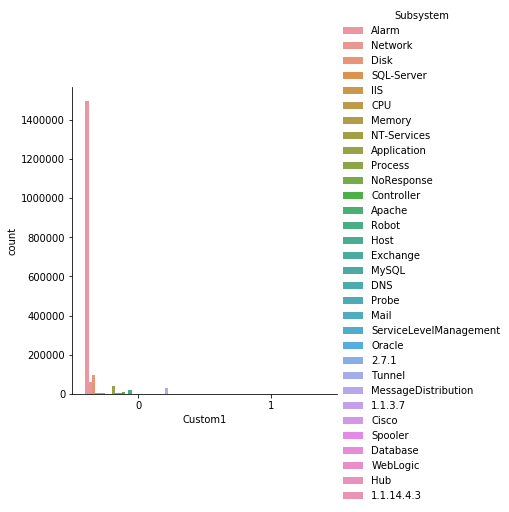

In [56]:
print(pd.crosstab(supervision.Subsystem, supervision.Custom1, normalize = 'index').round(4)*100)
plt.figure(figsize = (15, 8))
sns.catplot(x = "Custom1", hue = "Subsystem", kind = "count", data = supervision) #, hue="class" x = "Categorie", 
plt.show()

### Analyse multivariée : Custom1 X Visible X Duration_h

In [19]:
df_gptest = supervision[['Custom1','Visible','Duration_h']]
grouped_test1 = df_gptest.groupby(['Custom1','Visible'],as_index=False).mean()
grouped_test1

Custom1 Visible  Duration_h
0        0      No    0.188280
1        0     Yes    1.465051
2        1     Yes   16.967525

In [20]:
grouped_pivot = grouped_test1.pivot(index='Visible',columns='Custom1')
grouped_pivot

Duration_h           
Custom1          0          1
Visible                      
No        0.188280        NaN
Yes       1.465051  16.967525

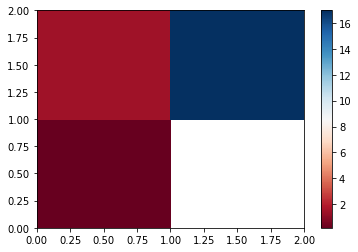

In [59]:
#use the grouped results
plt.pcolor(grouped_pivot, cmap='RdBu')
plt.colorbar()
plt.show()

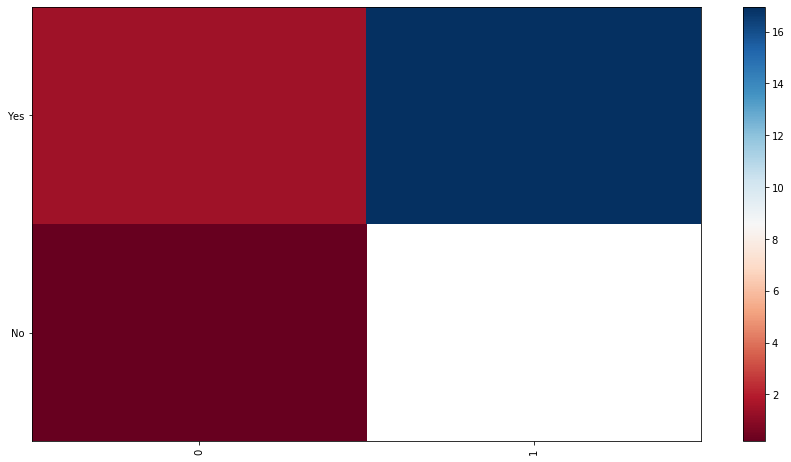

In [60]:
fig, ax = plt.subplots(figsize = (15, 8))
im = ax.pcolor(grouped_pivot, cmap='RdBu')

#label names
row_labels = grouped_pivot.columns.levels[1]
col_labels = grouped_pivot.index

#move ticks and labels to the center
ax.set_xticks(np.arange(grouped_pivot.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(grouped_pivot.shape[0]) + 0.5, minor=False)

#insert labels
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(col_labels, minor=False)

#rotate label if too long
plt.xticks(rotation=90)

fig.colorbar(im)
plt.show()

### Analyse multivariée : Custom1 X Subsystem X Duration_h

In [62]:
df_gptest = supervision[['Custom1','Subsystem','Duration_h']]
grouped_test2 = df_gptest.groupby(['Custom1','Subsystem'],as_index=False).mean()
grouped_test2

Custom1               Subsystem  Duration_h
0         0              1.1.14.4.3    0.151956
1         0                 1.1.3.7    0.091440
2         0                   2.7.1    0.090134
3         0                   Alarm    0.038707
4         0                  Apache    0.155102
5         0             Application    0.353456
6         0                     CPU    0.741523
7         0                   Cisco    0.647406
8         0              Controller    9.076464
9         0                     DNS    0.146647
10        0                Database    0.591389
11        0                    Disk    0.781159
12        0                Exchange    0.053495
13        0                    Host    1.315828
14        0                     Hub   44.726616
15        0                     IIS    0.835259
16        0                    Mail    0.105972
17        0                  Memory    5.110349
18        0     MessageDistribution    0.035130
19        0                   MySQL    2.771867
20        0             NT-Services    0.763754
21        0                 Network    0.683975
22        0              NoResponse    0.272910
23        0                  Oracle    0.185900
24        0                   Probe    0.646139
25        0                 Process   13.672668
26        0                   Robot    0.805343
27        0              SQL-Server    1.164709
28        0  ServiceLevelManagement    1.391111
29        0                 Spooler  123.403023
30        0                  Tunnel    0.078151
31        0                WebLogic    1.669861
32        1                 1.1.3.7    2.301389
33        1                   Alarm   23.234453
34        1                  Apache    3.616910
35        1             Application    8.310551
36        1                     CPU    4.132530
37        1                   Cisco    0.250833
38        1              Controller   16.862992
39        1                     DNS    3.402500
40        1                    Disk   34.067379
41        1                Exchange   13.601046
42        1                    Host   54.496806
43        1                     IIS    4.480340
44        1                  Memory   25.321258
45        1     MessageDistribution    3.430754
46        1                   MySQL    8.556171
47        1             NT-Services    5.647762
48        1                 Network   20.849201
49        1              NoResponse    5.119304
50        1                  Oracle    1.807393
51        1                   Probe   25.389572
52        1                 Process    4.691532
53        1                   Robot   13.597854
54        1              SQL-Server   13.782598
55        1  ServiceLevelManagement    3.412778
56        1                 Spooler   26.702714

In [63]:
grouped_pivot = grouped_test2.pivot(index='Subsystem',columns='Custom1')
grouped_pivot

Duration_h           
Custom1                          0          1
Subsystem                                    
1.1.14.4.3                0.151956        NaN
1.1.3.7                   0.091440   2.301389
2.7.1                     0.090134        NaN
Alarm                     0.038707  23.234453
Apache                    0.155102   3.616910
Application               0.353456   8.310551
CPU                       0.741523   4.132530
Cisco                     0.647406   0.250833
Controller                9.076464  16.862992
DNS                       0.146647   3.402500
Database                  0.591389        NaN
Disk                      0.781159  34.067379
Exchange                  0.053495  13.601046
Host                      1.315828  54.496806
Hub                      44.726616        NaN
IIS                       0.835259   4.480340
Mail                      0.105972        NaN
Memory                    5.110349  25.321258
MessageDistribution       0.035130   3.430754
MySQL                     2.771867   8.556171
NT-Services               0.763754   5.647762
Network                   0.683975  20.849201
NoResponse                0.272910   5.119304
Oracle                    0.185900   1.807393
Probe                     0.646139  25.389572
Process                  13.672668   4.691532
Robot                     0.805343  13.597854
SQL-Server                1.164709  13.782598
ServiceLevelManagement    1.391111   3.412778
Spooler                 123.403023  26.702714
Tunnel                    0.078151        NaN
WebLogic                  1.669861        NaN

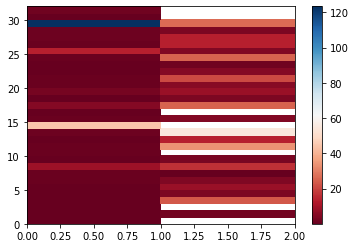

In [64]:
#use the grouped results
plt.pcolor(grouped_pivot, cmap='RdBu')
plt.colorbar()
plt.show()

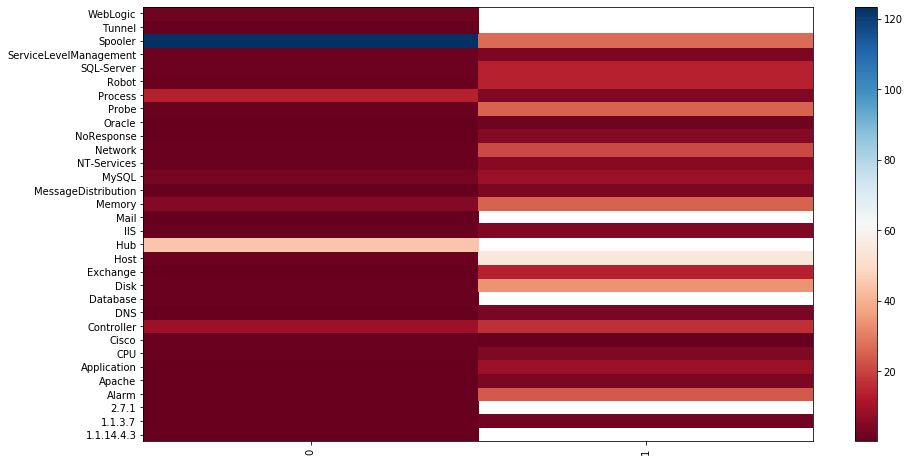

In [65]:
#plt.figure()
fig, ax = plt.subplots(figsize = (15, 8))
im = ax.pcolor(grouped_pivot, cmap='RdBu')

#label names
row_labels = grouped_pivot.columns.levels[1]
col_labels = grouped_pivot.index

#move ticks and labels to the center
ax.set_xticks(np.arange(grouped_pivot.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(grouped_pivot.shape[0]) + 0.5, minor=False)

#insert labels
ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(col_labels, minor=False)

#rotate label if too long
plt.xticks(rotation=90)

fig.colorbar(im)
plt.show()

### Analyse bivariée : Subsystem X Visible

In [66]:
pd.crosstab(supervision.Subsystem, supervision.Visible, normalize = 'index').round(4)*100

Visible                     No     Yes
Subsystem                             
1.1.14.4.3               54.17   45.83
1.1.3.7                  94.46    5.54
2.7.1                   100.00    0.00
Alarm                    99.37    0.63
Apache                    0.00  100.00
Application              82.40   17.60
CPU                      11.25   88.75
Cisco                    91.24    8.76
Controller               96.17    3.83
DNS                      81.22   18.78
Database                  0.00  100.00
Disk                     95.95    4.05
Exchange                 84.34   15.66
Host                     25.17   74.83
Hub                      54.55   45.45
IIS                      69.52   30.48
Mail                      0.00  100.00
Memory                    9.95   90.05
MessageDistribution      99.77    0.23
MySQL                    55.83   44.17
NT-Services              75.75   24.25
Network                  94.45    5.55
NoResponse               88.88   11.12
Oracle                   56.29   43.71
Probe                     0.04   99.96
Process                  56.83   43.17
Robot                    68.51   31.49
SQL-Server               84.03   15.97
ServiceLevelManagement    0.00  100.00
Spooler                   4.92   95.08
Tunnel                  100.00    0.00
WebLogic                  0.00  100.00

### Analyse bivariée : Severity X Subsystem

In [67]:
pd.crosstab(supervision.Subsystem, supervision.Severity, normalize = 'index').round(4)*100

Severity                    1       2      3       4       5
Subsystem                                                   
1.1.14.4.3               0.00    0.00   0.00  100.00    0.00
1.1.3.7                  0.00   96.79   0.00    3.21    0.00
2.7.1                    0.00    0.00   0.00    0.00  100.00
Alarm                    0.00    0.00   0.00    0.43   99.57
Apache                   0.00   15.57   0.00    0.00   84.43
Application              0.00    0.01   0.25   16.18   83.56
CPU                      0.00    0.00   0.79    0.77   98.44
Cisco                    0.00    0.00   0.00    0.00  100.00
Controller               0.00    0.00   0.00   94.95    5.05
DNS                      0.00    3.00   0.00   55.84   41.16
Database                 0.00    0.00   0.00    0.00  100.00
Disk                    93.81    0.00   0.04    3.79    2.37
Exchange                 0.00    0.00   0.00   98.33    1.67
Host                    25.17    0.00  74.83    0.00    0.00
Hub                      0.00  100.00   0.00    0.00    0.00
IIS                      0.00   75.94   8.53    0.00   15.52
Mail                     0.00    0.00   0.00  100.00    0.00
Memory                   5.85    1.14   0.00   71.04   21.96
MessageDistribution      0.00   99.87   0.00    0.00    0.13
MySQL                    0.00   18.97   0.00   23.85   57.18
NT-Services              0.00    0.00   0.00   53.65   46.35
Network                  0.00    0.69   0.00   45.99   53.32
NoResponse               0.00    0.00   0.00    0.00  100.00
Oracle                   0.00    0.00   0.00   91.02    8.98
Probe                    0.00    0.00   0.00   90.28    9.72
Process                  0.00    5.36   0.00    9.87   84.76
Robot                    0.00    0.00   0.00    0.00  100.00
SQL-Server               0.00    0.00   0.00   83.22   16.78
ServiceLevelManagement   0.00  100.00   0.00    0.00    0.00
Spooler                  0.00    0.00  74.32    0.00   25.68
Tunnel                   0.00    0.00   0.00    0.00  100.00
WebLogic                 0.00    0.00   0.00    0.00  100.00

## 2 - Analyse de la base tickets

La base *tickets* désigne les alertes pour lesquelles des tickets ont été créés. Elle est incluse dans la base *supervision*. On peut y trouver l'identifiant de la requête, son heure de création, sa catégorie, la priorité de la requête ainsi que son groupe.

### Affichage de la base

In [4]:
print(tickets.shape)
tickets.head()

(83999, 5)


ID de la requete    Heure de creation Categorie   Priorite  \
0            280377  2015-06-11 18:22:00   Demande   3-Faible   
1            319699  2016-02-03 17:04:00  Probleme  2-Moyenne   
2            340448  2016-05-31 17:52:00   Demande  2-Moyenne   
3            342031  2016-06-07 18:24:00   Demande  2-Moyenne   
4            350047  2016-07-29 11:51:00   Demande   3-Faible   

                Groupe  
0  Direction Technique  
1                  SSE  
2            Direction  
3            Direction  
4               EA PHP

In [5]:
tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83999 entries, 0 to 83998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID de la requete   83999 non-null  int64 
 1   Heure de creation  83999 non-null  object
 2   Categorie          83999 non-null  object
 3   Priorite           83999 non-null  object
 4   Groupe             83999 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.2+ MB


### Analyse de la colonne 'Categorie'

Evenement       30659
Demande         25993
Incident        13731
Notification    11760
Probleme         1856
Name: Categorie, dtype: int64


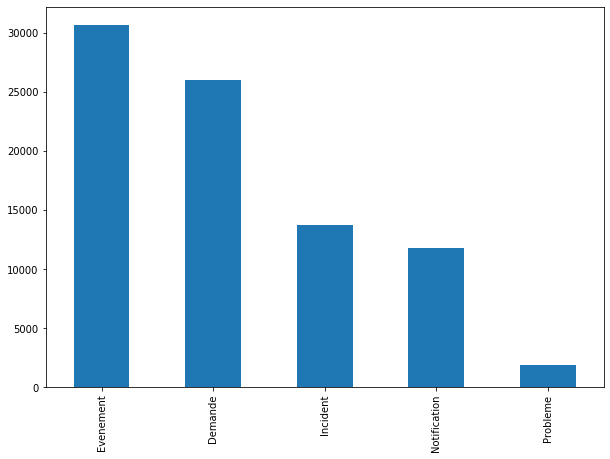

In [6]:
print(tickets['Categorie'].value_counts())
tickets['Categorie'].value_counts().plot.bar(figsize=(10,7))

### Analyse de la colonne 'Priorite'

2-Moyenne    60324
3-Faible     14951
1-Forte       8724
Name: Priorite, dtype: int64


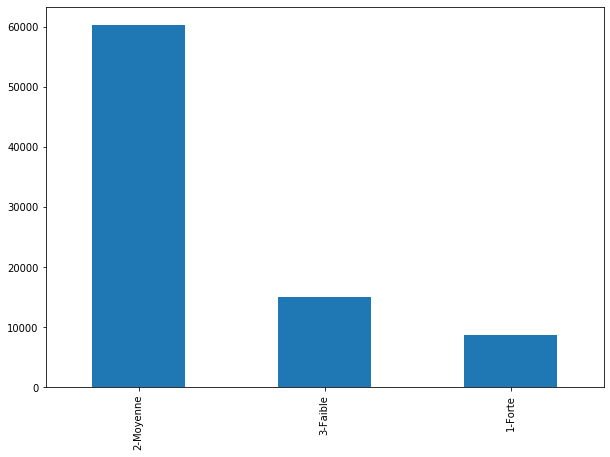

In [7]:
print(tickets['Priorite'].value_counts())
tickets['Priorite'].value_counts().plot.bar(figsize=(10,7))

<Figure size 1080x576 with 0 Axes>

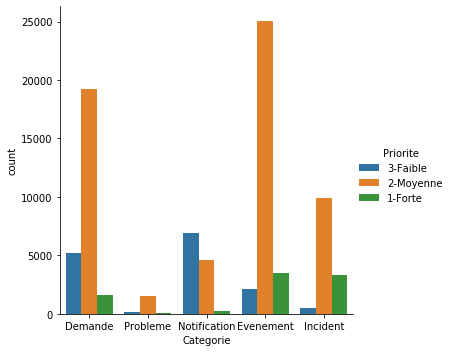

In [8]:
plt.figure(figsize = (15, 8))
sns.catplot(x = "Categorie", hue = "Priorite", kind = "count", data = tickets) #, hue="class" x = "Categorie", 
plt.show()

### Analyse de la colonne 'Groupe'

SSE                    60638
SSE Niveau2            11999
SOC                     2624
Direction Technique     2492
Support N3              2268
MES                     1173
Outils                  1030
SSE Paris                547
CAP                      538
Direction                171
CAB                      160
EA PHP                   134
EA                       115
EA Java                   81
SM                        21
EA Kiabi                   4
Gestion Problem            3
Actions                    1
Name: Groupe, dtype: int64


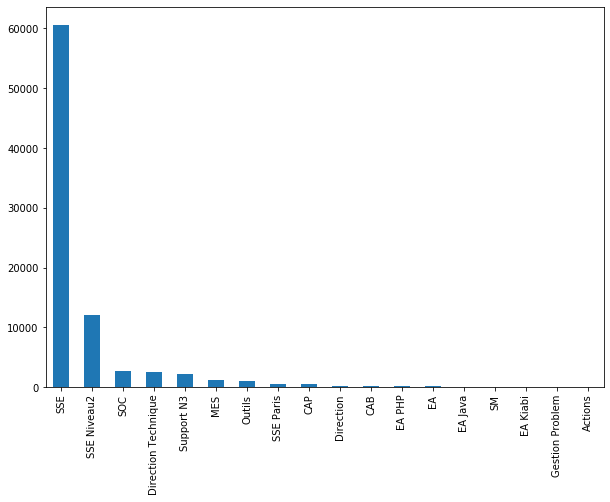

In [9]:
print(tickets['Groupe'].value_counts())
tickets['Groupe'].value_counts().plot.bar( figsize=(10,7))

In [10]:
tickets['Heure de creation'] = pd.to_datetime(tickets['Heure de creation'])
tickets['year_month'] = pd.to_datetime(tickets['Heure de creation']).dt.to_period('M')
tickets.head()

ID de la requete   Heure de creation Categorie   Priorite  \
0            280377 2015-06-11 18:22:00   Demande   3-Faible   
1            319699 2016-02-03 17:04:00  Probleme  2-Moyenne   
2            340448 2016-05-31 17:52:00   Demande  2-Moyenne   
3            342031 2016-06-07 18:24:00   Demande  2-Moyenne   
4            350047 2016-07-29 11:51:00   Demande   3-Faible   

                Groupe year_month  
0  Direction Technique    2015-06  
1                  SSE    2016-02  
2            Direction    2016-05  
3            Direction    2016-06  
4               EA PHP    2016-07

In [11]:
data_2019_2020 = tickets.iloc[np.where(tickets['year_month']>='2019-01')[0]]
data_2019_2020.head(10)

ID de la requete   Heure de creation     Categorie   Priorite  \
31228            503133 2019-01-01 01:09:00     Evenement  2-Moyenne   
31229            503134 2019-01-01 01:15:00     Evenement  2-Moyenne   
31230            503135 2019-01-01 01:47:00  Notification  2-Moyenne   
31231            503139 2019-01-01 02:32:00     Evenement  2-Moyenne   
31232            503143 2019-01-01 02:56:00     Evenement  2-Moyenne   
31233            503145 2019-01-01 02:56:00     Evenement  2-Moyenne   
31234            503146 2019-01-01 02:56:00     Evenement  2-Moyenne   
31235            503142 2019-01-01 02:56:00     Evenement  2-Moyenne   
31236            503140 2019-01-01 02:56:00     Evenement  2-Moyenne   
31237            503148 2019-01-01 04:53:00     Evenement  2-Moyenne   

            Groupe year_month  
31228          SSE    2019-01  
31229          SSE    2019-01  
31230          SSE    2019-01  
31231          SSE    2019-01  
31232          SSE    2019-01  
31233          SSE    2019-01  
31234  SSE Niveau2    2019-01  
31235  SSE Niveau2    2019-01  
31236          SSE    2019-01  
31237          SSE    2019-01

In [12]:
count_id = data_2019_2020['ID de la requete'].value_counts()
count_id


526335    1
557509    1
528855    1
530902    1
524757    1
         ..
535599    1
533550    1
539693    1
537644    1
524288    1
Name: ID de la requete, Length: 52771, dtype: int64

***Remarque*** : 
Sur la table ticket on a que des valeurs uniques des ID ( càd pas de doublons )

In [13]:
print("Le nombre de tickets créé dans la période 09-2019/03-2020 : ",len(count_id))

Le nombre de tickets créé dans la période 09-2019/03-2020 :  52771


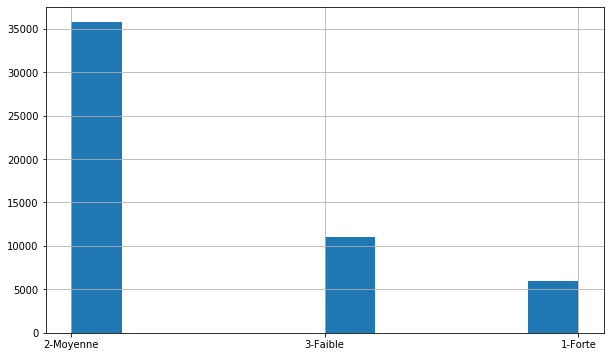

In [14]:
data_2019_2020['Priorite'].hist( figsize=(10,6))

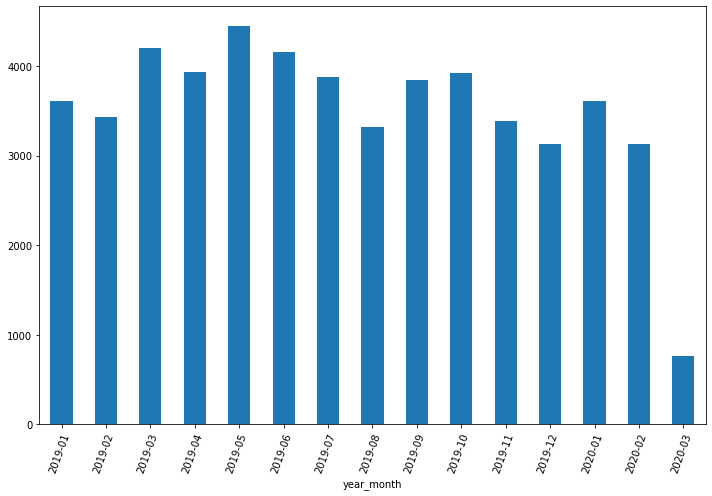

In [15]:
df_sample_grouped = data_2019_2020.groupby(['year_month']).size()
n_unique_dates = len(df_sample_grouped.index.unique())
fig = plt.figure( figsize=(10,7))
ax = (df_sample_grouped
      .plot
      .bar(x="year_month"))
ax.set_xticklabels(labels=df_sample_grouped.index, 
                   rotation=70, rotation_mode="anchor", ha="right");
plt.tight_layout()

## Création des colonnes Heure et Weekday

In [16]:
# Heure de création de l'alerte
tickets['Hour'] = pd.to_datetime(tickets['Heure de creation']).dt.to_period('H')
tickets['Heure'] = 0
# len(supervision)
for i in range(len(tickets)):
    tickets.iloc[i, 7] = tickets.iloc[i, 6].hour
    

# Jour de création de l'alerte
tickets["Weekday"] = tickets["Heure de creation"].dt.day_name()

# Supression de la colonne Hour
tickets = tickets.drop('Hour', axis = 1)


print(tickets.shape)
tickets.head()

(83999, 8)


ID de la requete   Heure de creation Categorie   Priorite  \
0            280377 2015-06-11 18:22:00   Demande   3-Faible   
1            319699 2016-02-03 17:04:00  Probleme  2-Moyenne   
2            340448 2016-05-31 17:52:00   Demande  2-Moyenne   
3            342031 2016-06-07 18:24:00   Demande  2-Moyenne   
4            350047 2016-07-29 11:51:00   Demande   3-Faible   

                Groupe year_month  Heure    Weekday  
0  Direction Technique    2015-06     18   Thursday  
1                  SSE    2016-02     17  Wednesday  
2            Direction    2016-05     17    Tuesday  
3            Direction    2016-06     18    Tuesday  
4               EA PHP    2016-07     11     Friday

# Ajout de la colonne semaine

In [17]:
tickets['Week'] = pd.to_datetime(tickets['Heure de creation']).dt.to_period('W')


In [18]:
tickets.head()

ID de la requete   Heure de creation Categorie   Priorite  \
0            280377 2015-06-11 18:22:00   Demande   3-Faible   
1            319699 2016-02-03 17:04:00  Probleme  2-Moyenne   
2            340448 2016-05-31 17:52:00   Demande  2-Moyenne   
3            342031 2016-06-07 18:24:00   Demande  2-Moyenne   
4            350047 2016-07-29 11:51:00   Demande   3-Faible   

                Groupe year_month  Heure    Weekday                   Week  
0  Direction Technique    2015-06     18   Thursday  2015-06-08/2015-06-14  
1                  SSE    2016-02     17  Wednesday  2016-02-01/2016-02-07  
2            Direction    2016-05     17    Tuesday  2016-05-30/2016-06-05  
3            Direction    2016-06     18    Tuesday  2016-06-06/2016-06-12  
4               EA PHP    2016-07     11     Friday  2016-07-25/2016-07-31

---
# Analyse de série chronologique (2)

Cette deuxième analyse de série chronologique est basée sur la base tickets uniquement (la première étant issue de la fusion des deux bases). En effet, la base ticket contient 80000 lignes environ, sans doublons. Elle est cependant observée sur une plus longue période (2015-2019). Un des avantages de l'étude de cette base est le nombre élevé d'observations. 

Certaines questions restent néanmoins en suspend :

- Pourquoi y'a-t'il autant de duplicata dans la base supervision?
- Pourquoi les dates de création dans les base supervision et tickets ne sont pas identiques?

In [52]:
df_series = pd.read_csv("../../Data/tickets_series.csv", index_col = "TimeCreated", parse_dates = True, sep = ";")

### Affichage de la série

In [53]:
print(df_series.shape)
df_series.head()

(858, 5)


Demande  Evenement  Incident  Notification  Probleme
TimeCreated                                                      
2015-06-11         1          0         0             0         0
2016-02-03         0          0         0             0         1
2016-05-31         1          0         0             0         0
2016-06-07         1          0         0             0         0
2016-07-29         1          0         0             0         0

### Ajout d'une colonne Total

La colonne 'Total' désigne le volume total de ticket créer sur la période.

In [54]:
df_series['Total'] = df_series.apply(np.sum, axis = 1)
print(df_series.shape)
df_series.head(5)

(858, 6)


Demande  Evenement  Incident  Notification  Probleme  Total
TimeCreated                                                             
2015-06-11         1          0         0             0         0      1
2016-02-03         0          0         0             0         1      1
2016-05-31         1          0         0             0         0      1
2016-06-07         1          0         0             0         0      1
2016-07-29         1          0         0             0         0      1

## Loi de Total

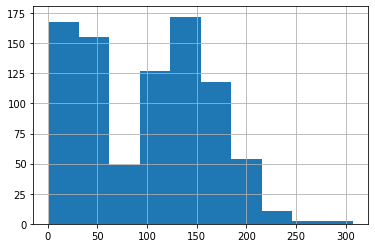

In [75]:
df_series['Total'].hist()

### Distributions des variables

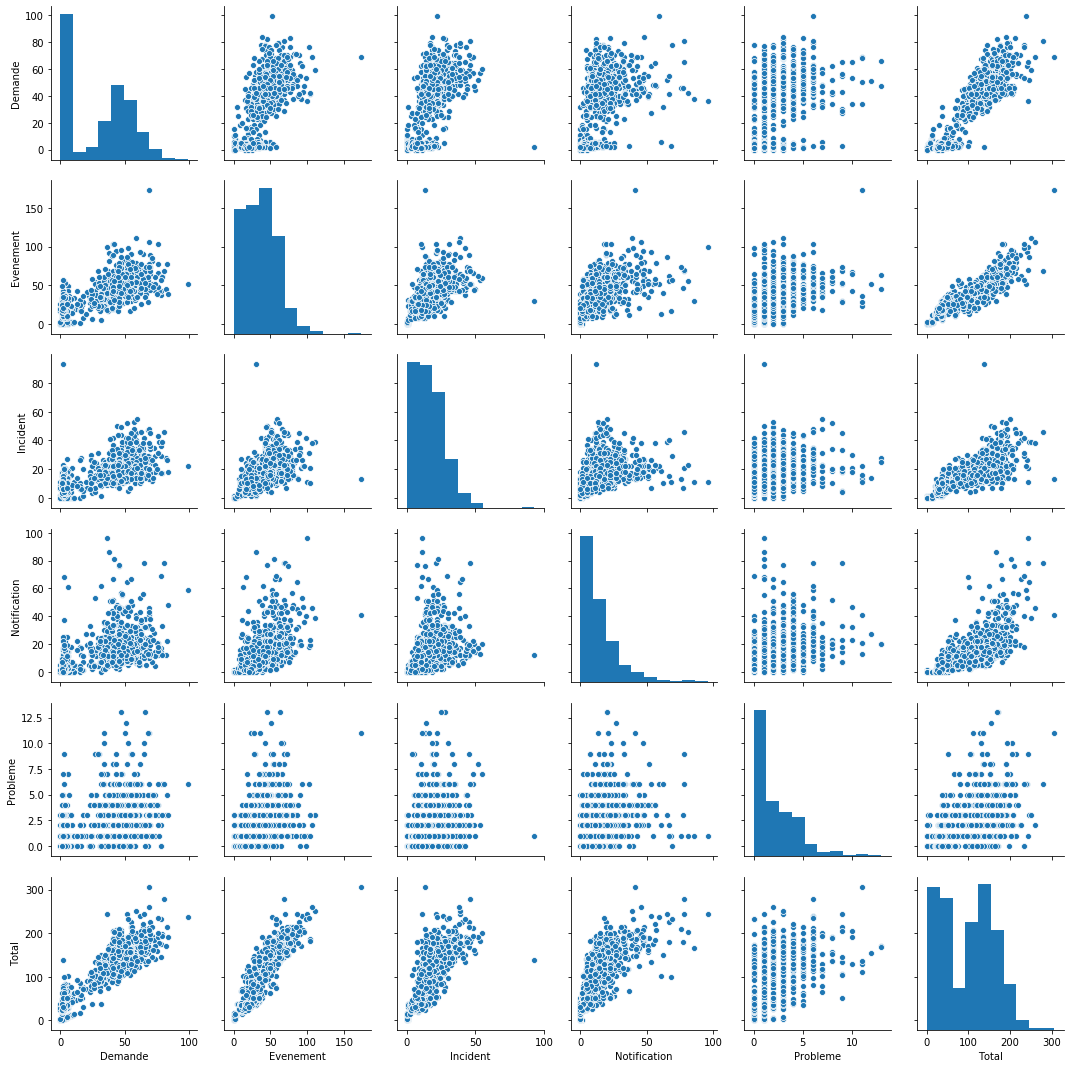

In [36]:
sns.pairplot(df_series)

### Correlation entre les variables

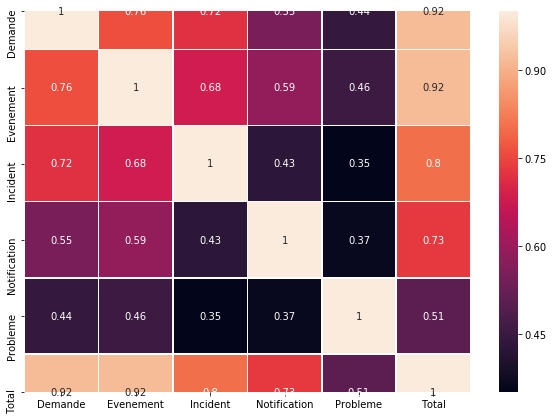

In [85]:
f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(df_series.corr(), annot=True, linewidths=.5, ax=ax)

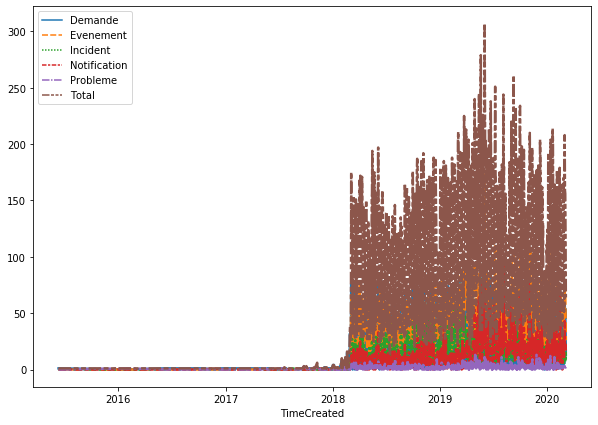

In [86]:
f, ax = plt.subplots(figsize=(10, 7))
sns.lineplot(data = df_series, palette="tab10", linewidth=2.5, ax = ax)

## Analyse du volume total de tickets créés entre 2019 et 2020

### Fréquence de tickets créés entre 2019 et 2020

In [119]:
Month = ['Janv', 'Fev', 'Mar', 'Avr', 'Mai', 'Jui', 'Jui', 'Aou', 'Sep', 'Oct', 'Nov', 'Dec']

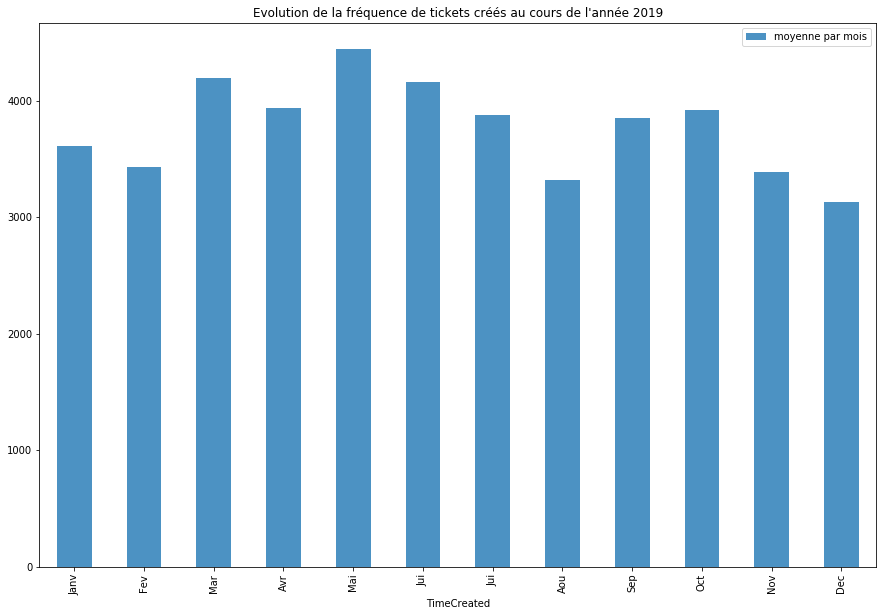

In [124]:
Month = ['Janv', 'Fev', 'Mar', 'Avr', 'Mai', 'Jui', 'Jui', 'Aou', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize = (15, 10))
df_series.loc['2019', 'Total'].resample('M').sum().plot(kind = 'bar', label = 'moyenne par mois', alpha = 0.8)
plt.title("Evolution de la fréquence de tickets créés au cours de l'année 2019")
plt.xticks(ticks = range(0, 12), labels = Month)
plt.legend()
plt.show()

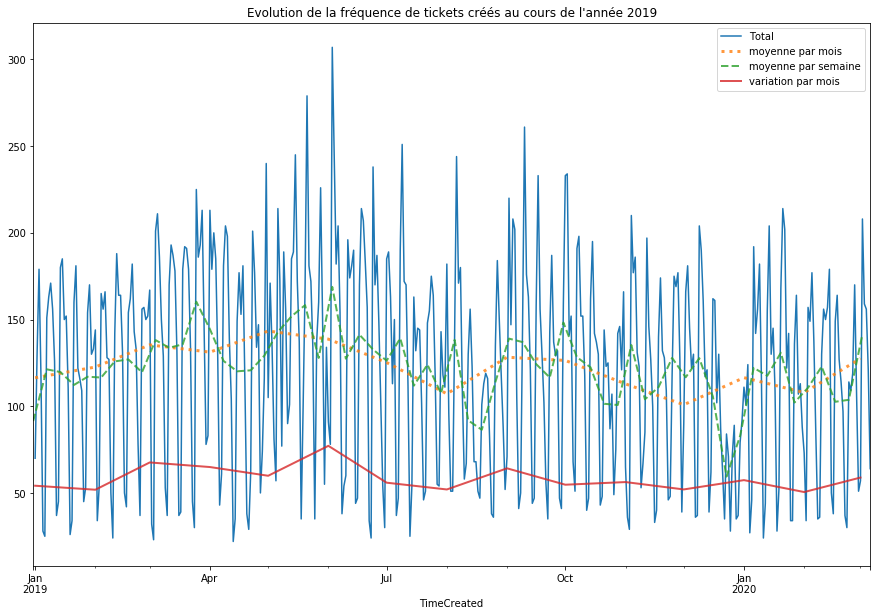

In [55]:
plt.figure(figsize = (15, 10))
df_series.loc['2019':'2020', 'Total'].plot()
df_series.loc['2019':'2020', 'Total'].resample('M').mean().plot(label = 'moyenne par mois', lw = 3, ls = ':', alpha = 0.8)
df_series.loc['2019':'2020', 'Total'].resample('W').mean().plot(label = 'moyenne par semaine', lw = 2, ls = '--', alpha = 0.8)
df_series.loc['2019':'2020', 'Total'].resample('M').std().plot(label = 'variation par mois', lw = 2, alpha = 0.8)
plt.title("Evolution de la fréquence de tickets créés au cours de l'année 2019")
plt.legend()
plt.show()

In [73]:

print('Moyenne : ', df_series.loc['2019':'2020', 'Total'].mean())
print('Mediane : ', df_series.loc['2019':'2020', 'Total'].median())


Moyenne :  122.4385150812065
Mediane :  130.0


- Présence de creux et pics réguliers indiquant la présence de saisonnalité
- La série semble néanmoins stationnaire au cours du temps
- On remarque un pic trés important au mois de mai

### Fréquence de tickets créés en 2019

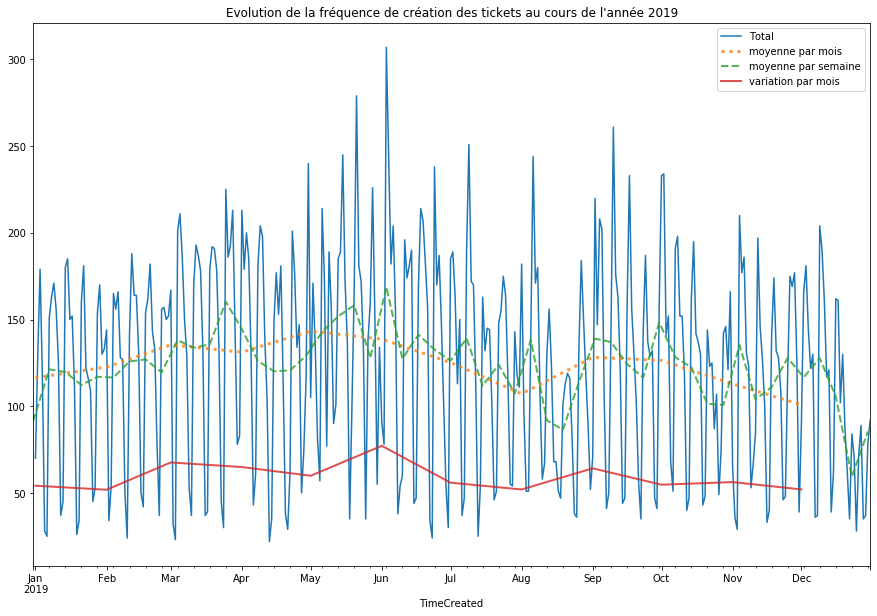

In [59]:
plt.figure(figsize = (15, 10))
df_series.loc['2019', 'Total'].plot()
df_series.loc['2019', 'Total'].resample('M').mean().plot(label = 'moyenne par mois', lw = 3, ls = ':', alpha = 0.8)
df_series.loc['2019', 'Total'].resample('W').mean().plot(label = 'moyenne par semaine', lw = 2, ls = '--', alpha = 0.8)
df_series.loc['2019', 'Total'].resample('M').std().plot(label = 'variation par mois', lw = 2, alpha = 0.8)
plt.title("Evolution de la fréquence de création des tickets au cours de l'année 2019")
plt.legend()
plt.show()

## Intervalle de confiance pour la moyenne

In [78]:
from math import sqrt

X_bar = df_series.loc['2019':'2020', 'Total'].mean()
Std = df_series.loc['2019':'2020', 'Total'].std()
ICinf = X_bar - 1.96*Std/sqrt(len(df_series))
ICsup = X_bar + 1.96*Std/sqrt(len(df_series))

## Volume moyen de tickets créés par semaine

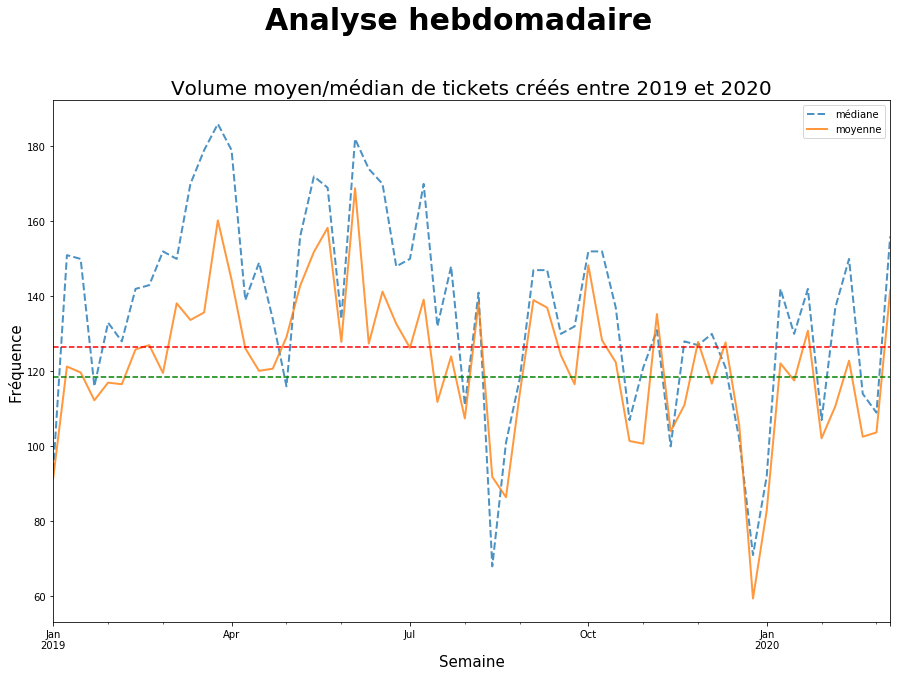

In [126]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
fig.suptitle('Analyse hebdomadaire', fontsize=30, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
#




df_series.loc['2019':'2020', 'Total'].resample('W').median().plot(label = 'médiane', lw = 2, ls = '--', alpha = 0.8)
df_series.loc['2019':'2020', 'Total'].resample('W').mean().plot(label = 'moyenne', lw = 2, alpha = 0.8)
plt.axhline(y = ICinf, color = 'green', linestyle='--')
plt.axhline(y = ICsup, color = 'red', linestyle='--')
#plt.axhline(y = df_series.loc['2019':'2020', 'Total'].mean(), color = 'orange')
#plt.axhline(y = df_series.loc['2019':'2020', 'Total'].median(), color = 'blue', linestyle='--')
ax.set_title('Volume moyen/médian de tickets créés entre 2019 et 2020', fontsize = 20)
#plt.title("Volume moyen/médian de tickets créés chaque semaine entre 2019 et 2020")
#plt.xlabel('Semaine')
#plt.ylabel('Fréquence')
ax.set_xlabel('Semaine', fontsize = 15)
ax.set_ylabel('Fréquence', fontsize = 15)

plt.legend()
plt.show()

***Remarque*** : On note la présence de points athypiques en mai et juin 2019. En mai 2019 on a une augmentation anormale du nombre d'incident, quelques jours plus tard c'est le nombre d'événement qui augmente brusquement. 

### Fréquence de tickets créés en 2020

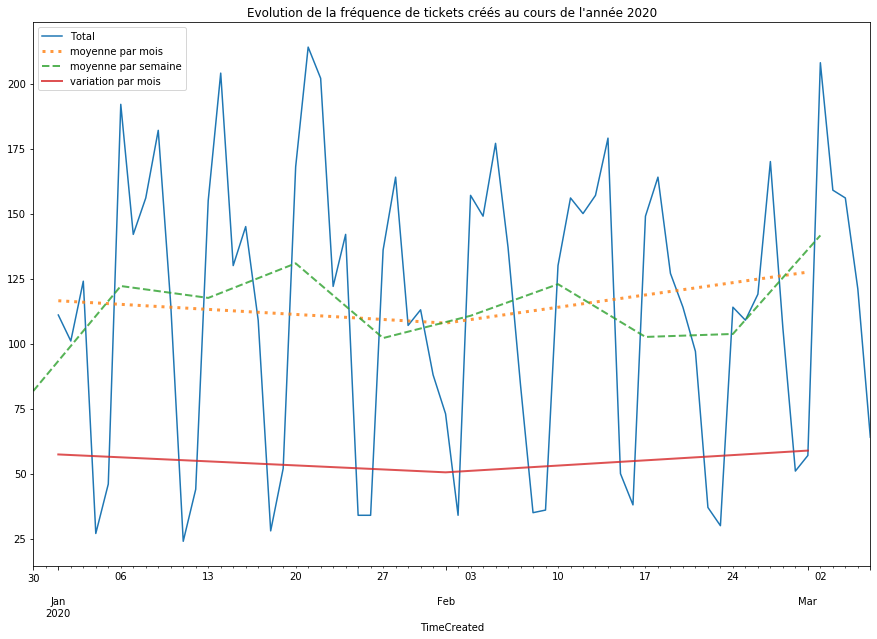

In [60]:
plt.figure(figsize = (15, 10))
df_series.loc['2020', 'Total'].plot()
df_series.loc['2020', 'Total'].resample('M').mean().plot(label = 'moyenne par mois', lw = 3, ls = ':', alpha = 0.8)
df_series.loc['2020', 'Total'].resample('W').mean().plot(label = 'moyenne par semaine', lw = 2, ls = '--', alpha = 0.8)
df_series.loc['2020', 'Total'].resample('M').std().plot(label = 'variation par mois', lw = 2, alpha = 0.8)
plt.title("Evolution de la fréquence de tickets créés au cours de l'année 2020")
plt.legend()
plt.show()

TimeCreated
2019-01-06    AxesSubplot(0.125,0.125;0.775x0.755)
2019-01-13    AxesSubplot(0.125,0.125;0.775x0.755)
2019-01-20    AxesSubplot(0.125,0.125;0.775x0.755)
2019-01-27    AxesSubplot(0.125,0.125;0.775x0.755)
2019-02-03    AxesSubplot(0.125,0.125;0.775x0.755)
                              ...                 
2020-02-09    AxesSubplot(0.125,0.125;0.775x0.755)
2020-02-16    AxesSubplot(0.125,0.125;0.775x0.755)
2020-02-23    AxesSubplot(0.125,0.125;0.775x0.755)
2020-03-01    AxesSubplot(0.125,0.125;0.775x0.755)
2020-03-08    AxesSubplot(0.125,0.125;0.775x0.755)
Freq: W-SUN, Name: Incident, Length: 62, dtype: object

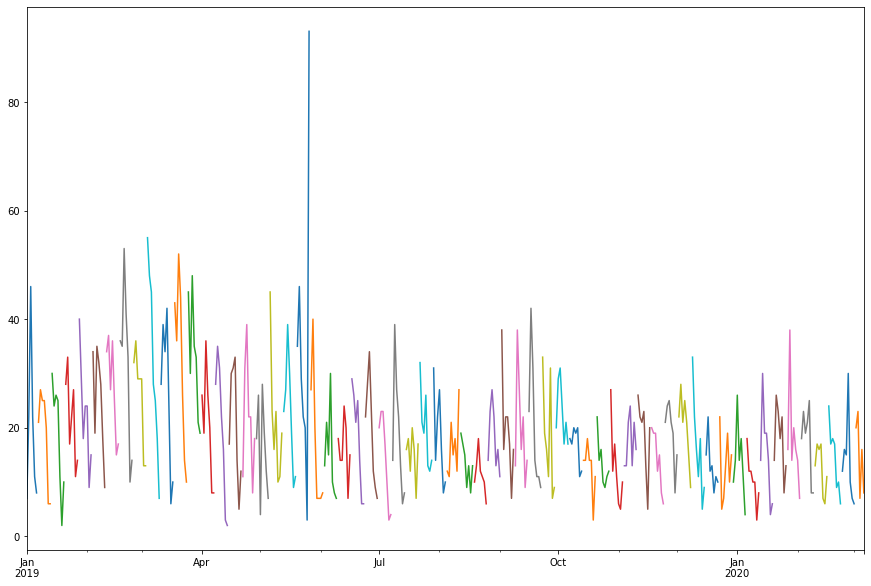

In [57]:
df_series.loc['2019' : '2020', 'Incident'].resample('W').plot(figsize = (15, 10))

- Le volume de ticket générés atteint son pic tous les mardis 
- Le niveau le plus bas est atteint chaque dimanche, ce qui corrobore l'hypothèse de saisonnalité. Cette hypothèse sera vérifiée plus bas.

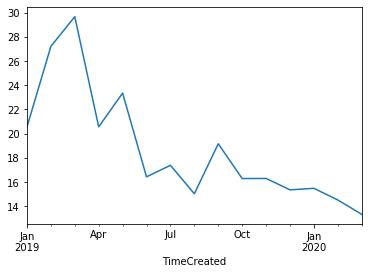

In [62]:
# La moyenne pour chaque mois
df_series.loc['2019':'2020', 'Incident'].resample('M').mean().plot()

- La figure ci-dessus représente la moyenne de la fréquence d'incident sur la période 2019-2020
- On peut constater une baise régulière de la fréquence moyenne d'incidents depuis mars 2019

### Volume des incidents entre 2019 et 2020

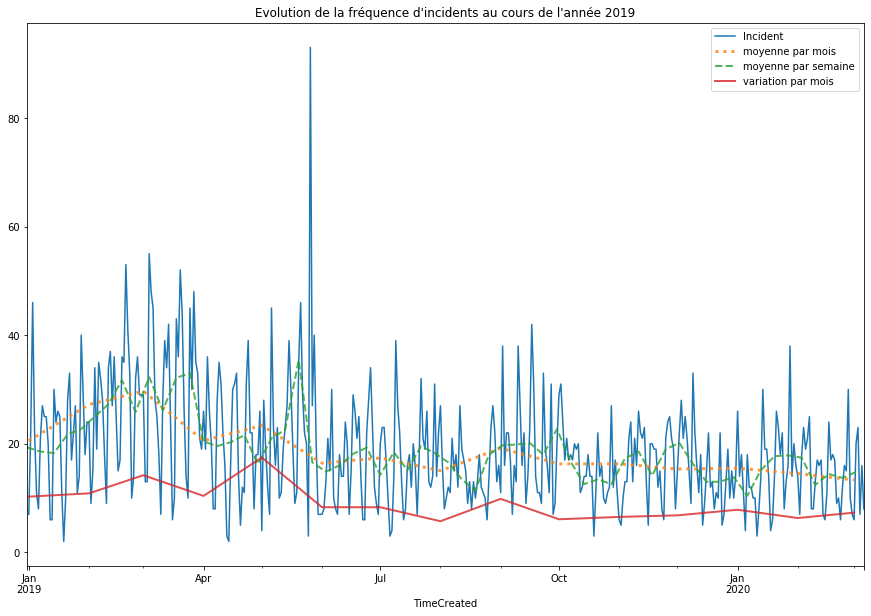

In [63]:
plt.figure(figsize = (15, 10))
df_series.loc['2019':'2020', 'Incident'].plot()
df_series.loc['2019':'2020', 'Incident'].resample('M').mean().plot(label = 'moyenne par mois', lw = 3, ls = ':', alpha = 0.8)
df_series.loc['2019':'2020', 'Incident'].resample('W').mean().plot(label = 'moyenne par semaine', lw = 2, ls = '--', alpha = 0.8)
df_series.loc['2019':'2020', 'Incident'].resample('M').std().plot(label = 'variation par mois', lw = 2, alpha = 0.8)
plt.title("Evolution de la fréquence d'incidents au cours de l'année 2019")
plt.legend()
plt.show()

## Calcul des autocorrélations

In [27]:
cor = acf(df_series.Incident)
cor

/home/lild01.pictime.fr/loukouj/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


array([1.        , 0.58060495, 0.38275439, 0.25489776, 0.2555844 ,
       0.33294698, 0.54670238, 0.65303999, 0.51272081, 0.31306864,
       0.22623997, 0.23925522, 0.30456527, 0.50258402, 0.62980579,
       0.48489226, 0.28524861, 0.20611886, 0.19949008, 0.27922578,
       0.48706671, 0.59687455, 0.47799245, 0.28162282, 0.18525762,
       0.18655962, 0.26366327, 0.43478525, 0.57603078, 0.44110035,
       0.26729206, 0.17562833, 0.1681344 , 0.2431953 , 0.42490648,
       0.5678829 , 0.41819686, 0.23666294, 0.15865711, 0.14428556,
       0.22665273])

Text(0.5, 1.0, 'Autocorrélogramme')

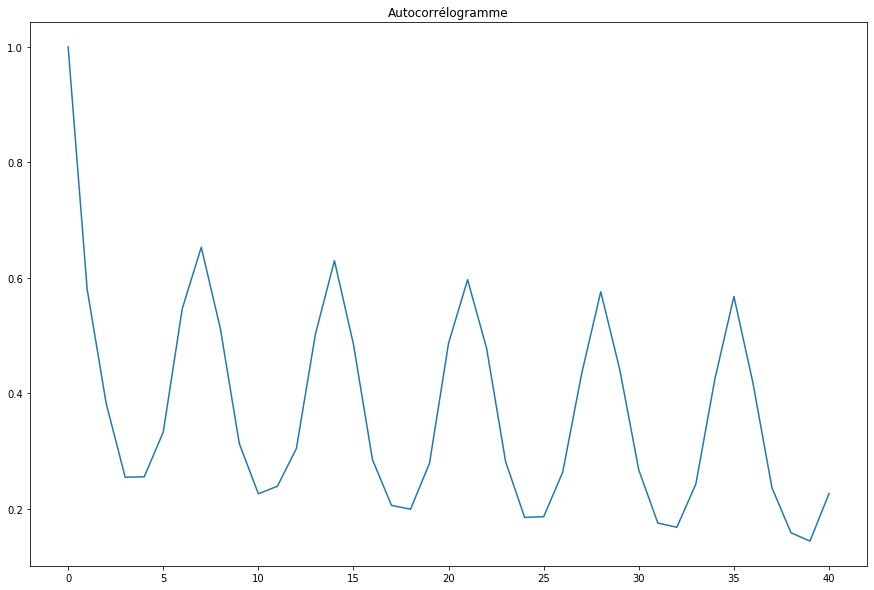

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
ax.plot(cor)
ax.set_title("Autocorrélogramme")

***Remarque***

L'autocorrélogramme de la série montre bien la présence de saisonalité. On peut observer des pics réguliers chaque semaine (jour 7, jour 14, jour 21...), ce qui correspond au mardi. Notre série est donc saisonnière avec une saisonalité hebdomadaire.

## Calcul des autocorrélations partielles

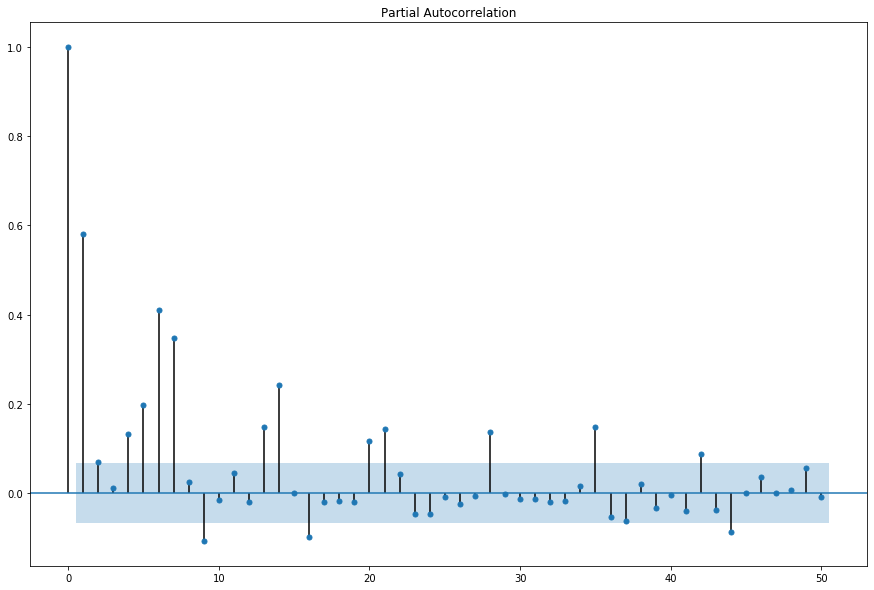

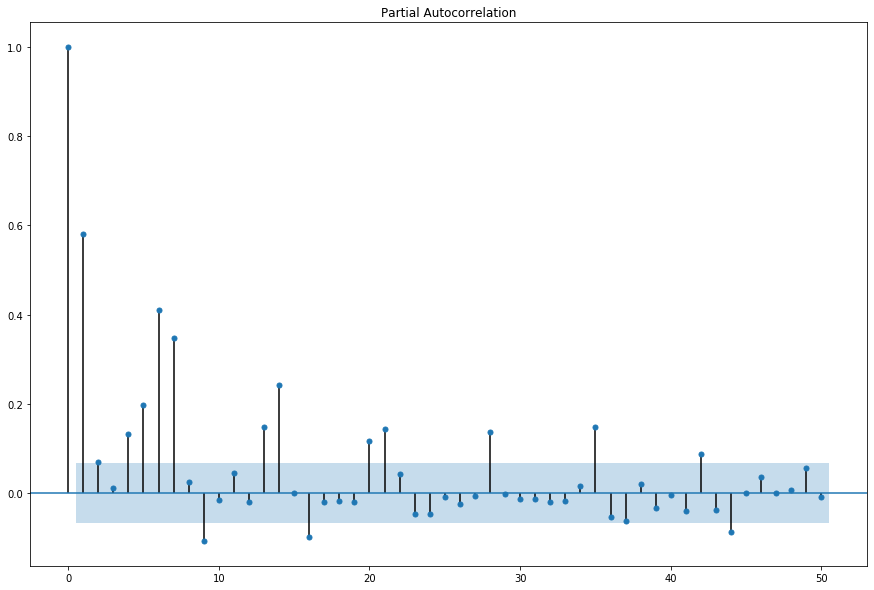

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
plot_pacf(df_series.Incident, lags=50, ax = ax)


L'autocorrélogramme partiel corrobore les résultats obtenus avec l'autocorrélogramme.

### Analyse fine des pics observés en mai et juin 2019

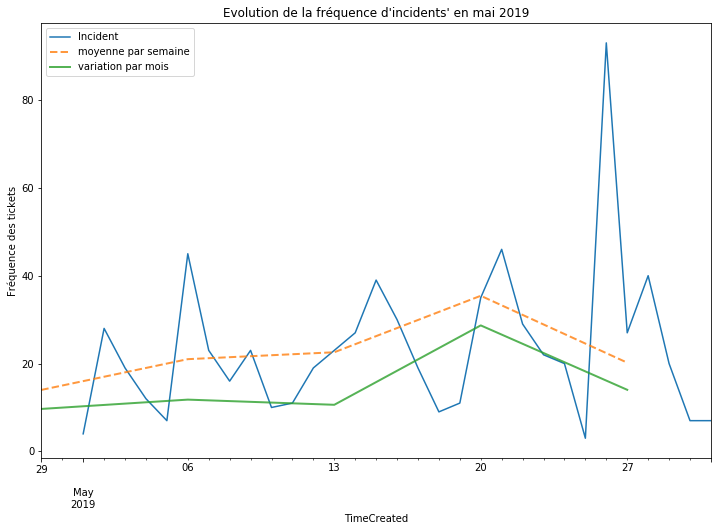

In [29]:
plt.figure(figsize = (12, 8))
df_series.loc['2019-05', 'Incident'].plot()
#df_series.loc['2019-05', 'Demande'].plot()
#df_series.loc['2019-05', 'Probleme'].plot()
#df_series.loc['2019-05', 'Incident'].resample('M').mean().plot(label = 'moyenne par mois', lw = 3, ls = ':', alpha = 0.8)
df_series.loc['2019-05', 'Incident'].resample('W').mean().plot(label = 'moyenne par semaine', lw = 2, ls = '--', alpha = 0.8)
df_series.loc['2019-05', 'Incident'].resample('W').std().plot(label = 'variation par mois', lw = 2, alpha = 0.8)
plt.ylabel("Fréquence des tickets")
plt.legend()
plt.title("Evolution de la fréquence d'incidents' en mai 2019")
plt.show()

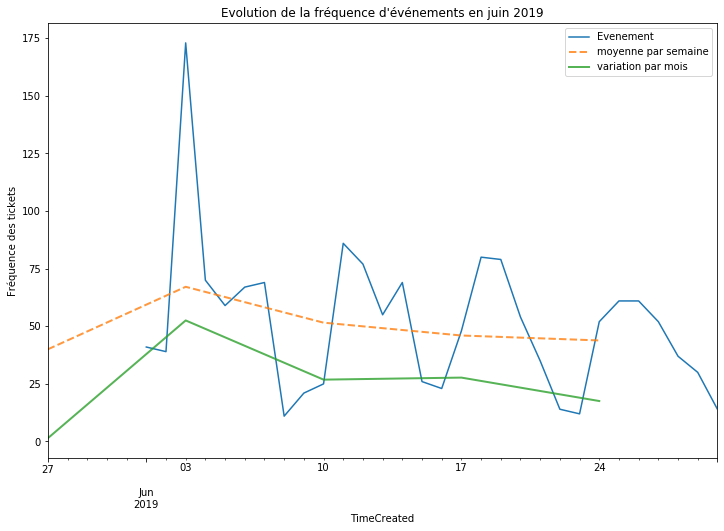

In [30]:
plt.figure(figsize = (12, 8))
df_series.loc['2019-06', 'Evenement'].plot()
df_series.loc['2019-06', 'Evenement'].resample('W').mean().plot(label = 'moyenne par semaine', lw = 2, ls = '--', alpha = 0.8)
df_series.loc['2019-06', 'Evenement'].resample('W').std().plot(label = 'variation par mois', lw = 2, alpha = 0.8)
plt.ylabel("Fréquence des tickets")
plt.legend()
plt.title("Evolution de la fréquence d'événements en juin 2019")
plt.show()

- Pic observé de la fréquence d'événements le 03 juin,
- Cependant, en observant la moyenne hebdomadaire de la fréquence d'événement au mois de juin, on remarque globalement une certaine constance de celle-ci,
- Ce constat est le même pour la variation du nombre d'événement sur le mois de juin

## Analyse journalière de la fréquence des tickets

L'objectif ici est d'observer la fréquence de création des tickets sur chaque jour de la semaine. Pour se faire, on s'intéresse au mois de janvier.

- Extraction des tickets générés en Janvier

- Extraction des tickets générés chaque jour de la semaine

- Calcul des volumes horaire de tickets

Extraction des tickets générés en Janvier 2020:

In [31]:
#janvier_2020 = tickets[tickets['year_month'] == '2020-01'] 

In [92]:
janvier_2020 = tickets[tickets['Heure de creation'] >= '2020-01-01']
janvier_2020 = janvier_2020[janvier_2020['Heure de creation'] <= '2020-02-04']

In [93]:
janvier_2020.tail()

ID de la requete   Heure de creation  Categorie   Priorite  \
80364            570310 2020-02-03 18:38:00   Incident  2-Moyenne   
80365            570311 2020-02-03 18:38:00  Evenement  2-Moyenne   
80366            570312 2020-02-03 18:53:00    Demande  2-Moyenne   
80367            570314 2020-02-03 20:04:00    Demande  2-Moyenne   
80368            570315 2020-02-03 22:55:00    Demande  2-Moyenne   

                    Groupe year_month  Heure Weekday  
80364  Direction Technique    2020-02     18  Monday  
80365                  SSE    2020-02     18  Monday  
80366                  SSE    2020-02     18  Monday  
80367          SSE Niveau2    2020-02     20  Monday  
80368          SSE Niveau2    2020-02     22  Monday

In [94]:
janvier_2020.shape

(3875, 8)

Création de la colonne jour de la semaine

In [35]:
janvier_2020["weekday"] = janvier_2020["Heure de creation"].dt.day_name()

Ajout de la colonne heure, pour l'heure de création de l'alerte

In [36]:
janvier_2020['Hour'] = pd.to_datetime(janvier_2020['Heure de creation']).dt.to_period('H')

In [37]:
janvier_2020.tail()

ID de la requete   Heure de creation  Categorie   Priorite  \
80364            570310 2020-02-03 18:38:00   Incident  2-Moyenne   
80365            570311 2020-02-03 18:38:00  Evenement  2-Moyenne   
80366            570312 2020-02-03 18:53:00    Demande  2-Moyenne   
80367            570314 2020-02-03 20:04:00    Demande  2-Moyenne   
80368            570315 2020-02-03 22:55:00    Demande  2-Moyenne   

                    Groupe year_month  Heure Weekday weekday              Hour  
80364  Direction Technique    2020-02     18  Monday  Monday  2020-02-03 18:00  
80365                  SSE    2020-02     18  Monday  Monday  2020-02-03 18:00  
80366                  SSE    2020-02     18  Monday  Monday  2020-02-03 18:00  
80367          SSE Niveau2    2020-02     20  Monday  Monday  2020-02-03 20:00  
80368          SSE Niveau2    2020-02     22  Monday  Monday  2020-02-03 22:00

In [40]:
janvier_2020.iloc[4, 7].hour

AttributeError: 'str' object has no attribute 'hour'

In [41]:
janvier_2020['Heure'] = 0
for i in range(len(janvier_2020)):
    janvier_2020.iloc[i, 8] = janvier_2020.iloc[i, 7].hour
    i += 1

AttributeError: 'str' object has no attribute 'hour'

Calcul de la fréquence d'alerte par jour et par heure

In [95]:
df_lundi = janvier_2020[janvier_2020['Weekday'] == 'Monday'] 
df_mardi = janvier_2020[janvier_2020['Weekday'] == 'Tuesday'] 
df_mercredi = janvier_2020[janvier_2020['Weekday'] == 'Wednesday'] 
df_jeudi = janvier_2020[janvier_2020['Weekday'] == 'Thursday'] 
df_vendredi = janvier_2020[janvier_2020['Weekday'] == 'Friday'] 
df_samedi = janvier_2020[janvier_2020['Weekday'] == 'Saturday'] 
df_dimanche = janvier_2020[janvier_2020['Weekday'] == 'Sunday'] 

In [52]:
df_lundi.to_csv('df_lundi.csv')
df_mardi.to_csv('df_mardi.csv')
df_mercredi.to_csv('df_mercredi.csv')
df_jeudi.to_csv('df_jeudi.csv')
df_vendredi.to_csv('df_vendredi.csv')
df_samedi.to_csv('df_samedi.csv')
df_dimanche.to_csv('df_dimanche.csv')

Lundi

In [96]:
orange = sns.light_palette("orange", as_cmap=True)
pd.crosstab(df_lundi.Heure, df_lundi.Categorie).style.background_gradient(cmap=orange) #, margins = True, margins_name = 'Total'

Mardi

In [54]:
orange = sns.light_palette("orange", as_cmap=True)
pd.crosstab(df_mardi.Heure, df_mardi.Categorie).style.background_gradient(cmap=orange) #, margins = True, margins_name = 'Total'

Mercredi

In [55]:
orange = sns.light_palette("orange", as_cmap=True)
pd.crosstab(df_mercredi.Heure, df_mercredi.Categorie).style.background_gradient(cmap=orange) #, margins = True, margins_name = 'Total'

Jeudi

In [56]:
orange = sns.light_palette("orange", as_cmap=True)
pd.crosstab(df_jeudi.Heure, df_jeudi.Categorie).style.background_gradient(cmap=orange) #, margins = True, margins_name = 'Total'

On récupère à présent les diférentes séries journalières obtenues à partir du logiciel R:

- series_lundi
- series_mardi
- series_mercredi
- series_jeudi
- series_vendredi
- series_samedi
- series_dimanche

In [98]:
lundi = pd.read_csv("../../Data/series_lundi.csv", sep = ";")
mardi = pd.read_csv("../../Data/series_mardi.csv", sep = ";")
mercredi = pd.read_csv("../../Data/series_mercredi.csv", sep = ";")
jeudi = pd.read_csv("../../Data/series_jeudi.csv", sep = ";")
vendredi = pd.read_csv("../../Data/series_vendredi.csv", sep = ";")
samedi = pd.read_csv("../../Data/series_samedi.csv", sep = ";")
dimanche = pd.read_csv("../../Data/series_dimanche.csv", sep = ";")

In [99]:
# On calcule à présent le total d'alertes reçue sur une heure
lundi['Total_lundi'] = lundi.apply(np.sum, axis = 1)
mardi['Total_mardi'] = mardi.apply(np.sum, axis = 1)
mercredi['Total_mercredi'] = mercredi.apply(np.sum, axis = 1)
jeudi['Total_jeudi'] = jeudi.apply(np.sum, axis = 1)
vendredi['Total_vendredi'] = vendredi.apply(np.sum, axis = 1)
samedi['Total_samedi'] = samedi.apply(np.sum, axis = 1)
dimanche['Total_dimanche'] = dimanche.apply(np.sum, axis = 1)

In [100]:
lundi.head()

Unnamed: 0  Heure  Demande  Evenement  Incident  Notification  Probleme  \
0           1      0        1          4         4             2         0   
1           2      1        0          2         1             3         0   
2           3      2        0          3         1             4         0   
3           4      3        0          2         1             3         0   
4           5      4        0          6         1             0         1   

   Total_lundi  
0           12  
1            9  
2           13  
3           13  
4           17

Jointure des 7 tables, en gardant à chaque fois le nombre total de tickets créés.

In [101]:
result1 = pd.merge(lundi, mardi, how = 'outer', on = 'Heure')
result2 = pd.merge(mercredi, jeudi, how = 'outer', on = 'Heure')
result3 = pd.merge(vendredi, samedi, how = 'outer', on = 'Heure')
result4 = pd.merge(result3, dimanche, how = 'outer', on = 'Heure')

In [102]:
result5 = pd.merge(result1, result2, how = 'outer', on = 'Heure')

In [103]:
result6 = pd.merge(result5, result4, how = 'outer', on = 'Heure')

In [104]:
df_result = result6[['Total_lundi', 'Total_mardi', 'Total_mercredi', 'Total_jeudi', 'Total_vendredi', 'Total_samedi', 'Total_dimanche']]

### Calcul de la moyenne de tickets générés chaque heure, chaque jour

In [105]:
df_result = df_result/5
df_result.head()

Total_lundi  Total_mardi  Total_mercredi  Total_jeudi  Total_vendredi  \
0          2.4          2.8             2.4          1.2             2.6   
1          1.8          3.6             3.6          3.4             3.0   
2          2.6          3.6             2.2          4.4             4.2   
3          2.6          4.0             4.0          3.8             4.2   
4          3.4          6.4             4.2          3.6             4.6   

   Total_samedi  Total_dimanche  
0           2.8             1.8  
1           3.0             2.4  
2           1.4             2.2  
3           2.2             2.8  
4           2.8             3.4

In [106]:
df_result.describe()

Total_lundi  Total_mardi  Total_mercredi  Total_jeudi  Total_vendredi  \
count    24.000000    24.000000       24.000000    24.000000       24.000000   
mean     11.533333    10.833333       10.683333    10.325000        9.616667   
std       6.534368     4.985428        4.959634     6.474784        4.554183   
min       1.800000     2.800000        2.200000     1.200000        2.600000   
25%       5.000000     8.500000        5.900000     5.150000        5.200000   
50%      11.500000    10.800000       11.200000    10.200000        9.900000   
75%      17.800000    13.850000       14.900000    13.100000       12.600000   
max      21.200000    24.000000       17.400000    30.400000       16.800000   

       Total_samedi  Total_dimanche  
count     24.000000        24.00000  
mean       6.350000         6.55000  
std        2.727796         3.13757  
min        1.400000         1.80000  
25%        4.400000         3.35000  
50%        6.500000         7.20000  
75%        8.400000         9.05000  
max       11.400000        11.40000

In [100]:
df = pd.DataFrame({'loc': [9, 11.5, 12, 13.5, 14, 15.5, 17],
  'min': [15, 0, 15, 0, 15, 15, 0], 'max': [30, 15, 30, 15, 30, 30, 15]})



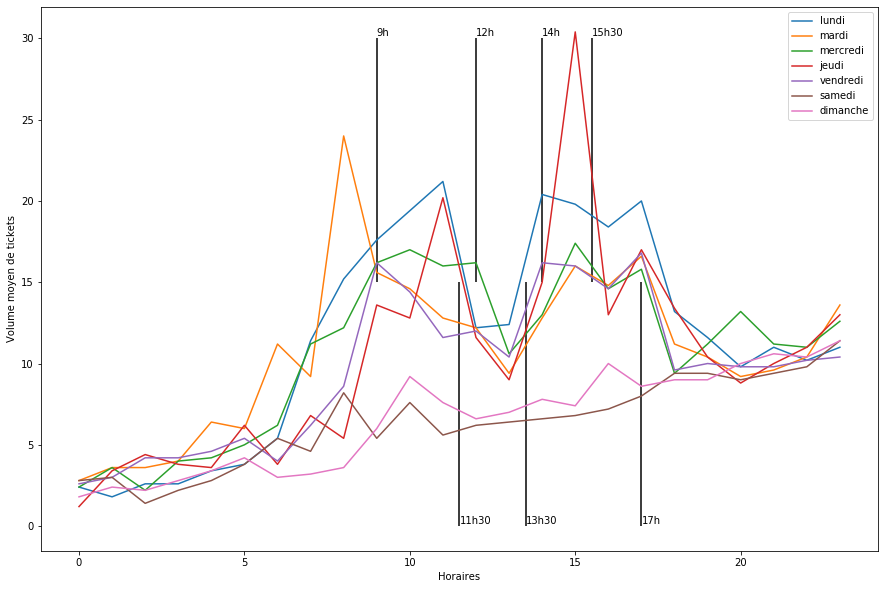

In [98]:
plt.figure(figsize = (15, 10))
plt.plot(df_result['Total_lundi'], label = "lundi")
plt.plot(df_result['Total_mardi'], label = "mardi")
plt.plot(df_result['Total_mercredi'], label = "mercredi")

plt.plot(df_result['Total_jeudi'], label = "jeudi")
plt.plot(df_result['Total_vendredi'], label = "vendredi")

plt.plot(df_result['Total_samedi'], label = "samedi")
plt.plot(df_result['Total_dimanche'], label = "dimanche")

plt.vlines(x = 'loc', data = df, ymin = 'min', ymax = 'max', linestyle = 'solid')



# Annotate Text
plt.annotate('9h', # text to display
             xy=(9, 30),                    # start the text at at point (year 2008 , pop 30)
             rotation=None,                  # based on trial and error to match the arrow
             va='bottom',                    # want the text to be vertically 'bottom' aligned
             ha='left',                      # want the text to be horizontally 'left' algned.
            )

plt.annotate('11h30', # text to display
             xy=(11.5, 0),                    
             rotation=None,                 
             va='bottom',                   
             ha='left',                     
            )

plt.annotate('12h', # text to display
             xy=(12, 30),                    
             rotation=None,                 
             va='bottom',                   
             ha='left',                     
            )


plt.annotate('13h30', # text to display
             xy=(13.5, 0),                    
             rotation=None,                 
             va='bottom',                   
             ha='left',                     
            )


plt.annotate('14h', # text to display
             xy=(14, 30),                    
             rotation=None,                 
             va='bottom',                   
             ha='left',                     
            )


plt.annotate('15h30', # text to display
             xy=(15.5, 30),                    
             rotation=None,                 
             va='bottom',                   
             ha='left',                     
            )


plt.annotate('17h', # text to display
             xy=(17, 0),                    
             rotation=None,                 
             va='bottom',                   
             ha='left',                     
            )


plt.xlabel('Horaires')
plt.ylabel('Volume moyen de tickets')


plt.legend()

plt.show()

Etude comparative : Vendredi, Samedi et Dimanche

In [66]:
df_VSD = df_result[['Total_vendredi', 'Total_samedi', 'Total_dimanche']]

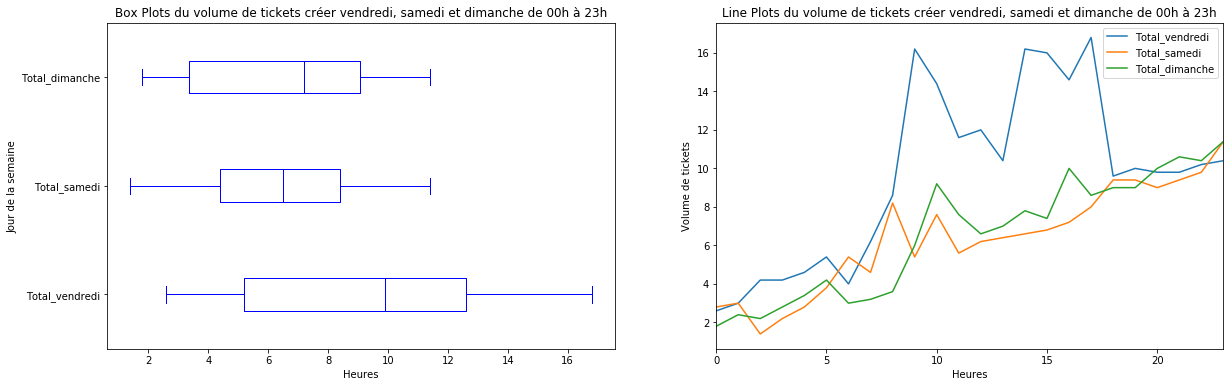

In [67]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Box plot
df_VSD.plot(kind='box', color='blue', vert=False, figsize=(20, 6), ax=ax0) # add to subplot 1
ax0.set_title('Box Plots du volume de tickets créer vendredi, samedi et dimanche de 00h à 23h')
ax0.set_xlabel('Heures')
ax0.set_ylabel('Jour de la semaine')

# Subplot 2: Line plot
df_VSD.plot(kind='line', figsize=(20, 6), ax=ax1) # add to subplot 2
ax1.set_title ('Line Plots du volume de tickets créer vendredi, samedi et dimanche de 00h à 23h')
ax1.set_ylabel('Volume de tickets')
ax1.set_xlabel('Heures')

plt.show()

Etude comparative: Lundi, Mardi, Mercredi, Jeudi

In [68]:
df_LMMJ = df_result[['Total_lundi', 'Total_mardi', 'Total_mercredi', 'Total_jeudi']]

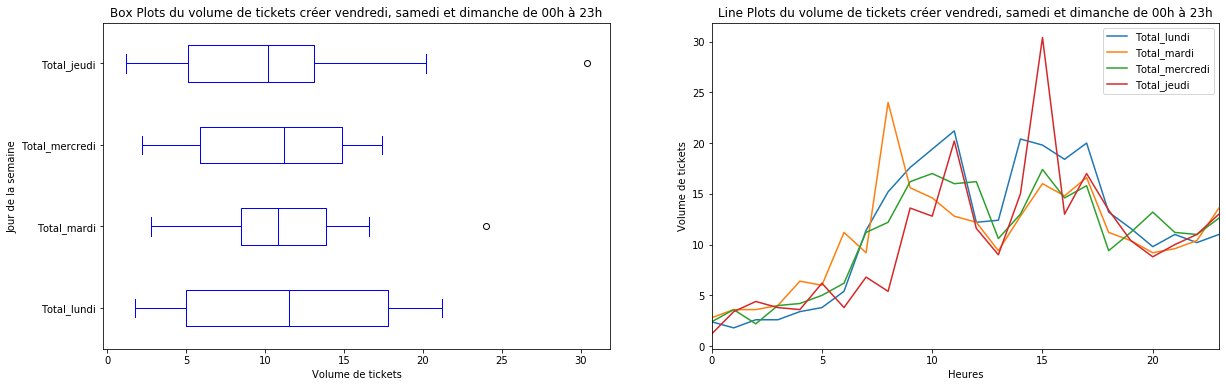

In [69]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Box plot
df_LMMJ.plot(kind='box', color='blue', vert=False, figsize=(20, 6), ax=ax0) # add to subplot 1
ax0.set_title('Box Plots du volume de tickets créer vendredi, samedi et dimanche de 00h à 23h')
ax0.set_xlabel('Volume de tickets')
ax0.set_ylabel('Jour de la semaine')

# Subplot 2: Line plot
df_LMMJ.plot(kind='line', figsize=(20, 6), ax=ax1) # add to subplot 2
ax1.set_title ('Line Plots du volume de tickets créer vendredi, samedi et dimanche de 00h à 23h')
ax1.set_ylabel('Volume de tickets')
ax1.set_xlabel('Heures')

plt.show()

# Affinement des résultats

L'objectif dans cette partie est d'affiner les résultats déjà obtenus ci-dessus. L'étude est réalisée avec les données observées sur l'année 2019.
- On récupère les données de 2019,
- On calcule pour chaque jour de chaque semaine, le volume de tickets créés

# Sélection de 2019

In [ ]:
tick = tickets.copy()
tick_2019 = tick[tick['Heure de creation'] >= '2019-01-01']
tick_2019 = tick_2019[tick_2019['Heure de creation'] < '2020-01-01']


# Pour chaque jour de 2019 on calcule le nombre de tickets

In [32]:

s_lundi = tick_2019[tick_2019['Weekday'] == 'Monday']
s_mardi = tick_2019[tick_2019['Weekday'] == 'Tuesday']
s_mercredi = tick_2019[tick_2019['Weekday'] == 'Wednesday']
s_jeudi = tick_2019[tick_2019['Weekday'] == 'Thursday']
s_vendredi = tick_2019[tick_2019['Weekday'] == 'Friday']
s_samedi = tick_2019[tick_2019['Weekday'] == 'Saturday']
s_dimanche = tick_2019[tick_2019['Weekday'] == 'Sunday']


df_l = pd.DataFrame(pd.crosstab(s_lundi.Heure, s_lundi.Week))
df_ma = pd.DataFrame(pd.crosstab(s_mardi.Heure, s_mardi.Week))
df_me = pd.DataFrame(pd.crosstab(s_mercredi.Heure, s_mercredi.Week))
df_j = pd.DataFrame(pd.crosstab(s_jeudi.Heure, s_jeudi.Week))
df_v = pd.DataFrame(pd.crosstab(s_vendredi.Heure, s_vendredi.Week))
df_s = pd.DataFrame(pd.crosstab(s_samedi.Heure, s_samedi.Week))
df_d = pd.DataFrame(pd.crosstab(s_dimanche.Heure, s_dimanche.Week))


# Représentation graphique

## Lundi

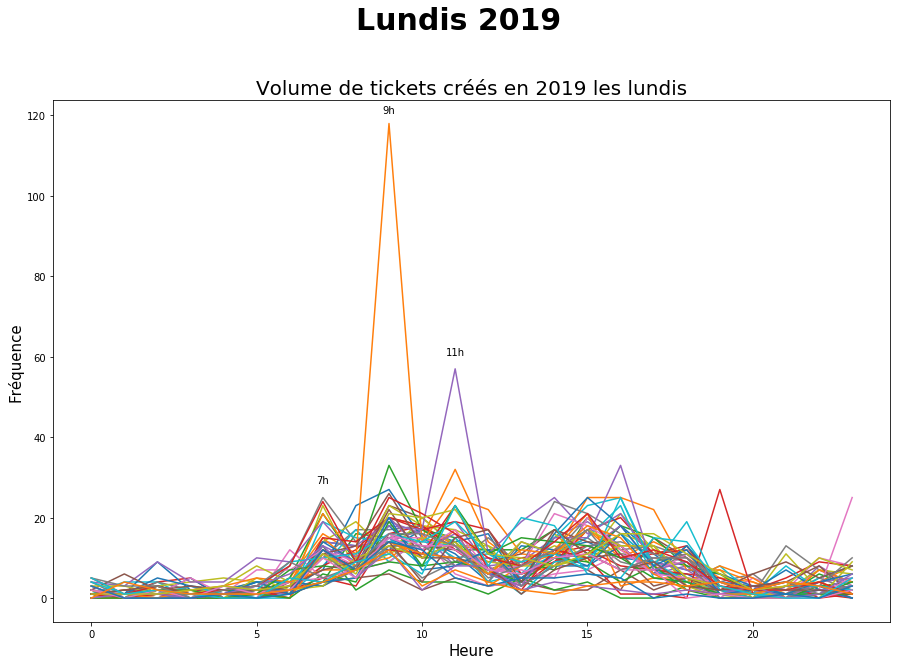

In [51]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
fig.suptitle('Lundis 2019', fontsize=30, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
#

#df_l.plot()
plt.plot(df_l)

plt.annotate('7h', # text to display
             xy=(7, 28),                    
             rotation=None,                 
             va='bottom',                   
             ha='center',                     
            )

plt.annotate('9h', # text to display
             xy=(9, 120),                    
             rotation=None,                 
             va='bottom',                   
             ha='center',                     
            )

plt.annotate('11h', # text to display
             xy=(11, 60),                    
             rotation=None,                 
             va='bottom',                   
             ha='center',                     
            )



ax.set_title('Volume de tickets créés en 2019 les lundis', fontsize = 20)
ax.set_xlabel('Heure', fontsize = 15)
ax.set_ylabel('Fréquence', fontsize = 15)

#plt.legend()
plt.show()

In [44]:
df_l[df_l.loc[:,:] > 40]

Week   2019-01-07/2019-01-13  2019-01-14/2019-01-20  2019-01-21/2019-01-27  \
Heure                                                                        
0                        NaN                    NaN                    NaN   
1                        NaN                    NaN                    NaN   
2                        NaN                    NaN                    NaN   
3                        NaN                    NaN                    NaN   
4                        NaN                    NaN                    NaN   
5                        NaN                    NaN                    NaN   
6                        NaN                    NaN                    NaN   
7                        NaN                    NaN                    NaN   
8                        NaN                    NaN                    NaN   
9                        NaN                    NaN                    NaN   
10                       NaN                    NaN                    NaN   
11                       NaN                    NaN                    NaN   
12                       NaN                    NaN                    NaN   
13                       NaN                    NaN                    NaN   
14                       NaN                    NaN                    NaN   
15                       NaN                    NaN                    NaN   
16                       NaN                    NaN                    NaN   
17                       NaN                    NaN                    NaN   
18                       NaN                    NaN                    NaN   
19                       NaN                    NaN                    NaN   
20                       NaN                    NaN                    NaN   
21                       NaN                    NaN                    NaN   
22                       NaN                    NaN                    NaN   
23                       NaN                    NaN                    NaN   

Week   2019-01-28/2019-02-03  2019-02-04/2019-02-10  2019-02-11/2019-02-17  \
Heure                                                                        
0                        NaN                    NaN                    NaN   
1                        NaN                    NaN                    NaN   
2                        NaN                    NaN                    NaN   
3                        NaN                    NaN                    NaN   
4                        NaN                    NaN                    NaN   
5                        NaN                    NaN                    NaN   
6                        NaN                    NaN                    NaN   
7                        NaN                    NaN                    NaN   
8                        NaN                    NaN                    NaN   
9                        NaN                    NaN                    NaN   
10                       NaN                    NaN                    NaN   
11                       NaN                    NaN                    NaN   
12                       NaN                    NaN                    NaN   
13                       NaN                    NaN                    NaN   
14                       NaN                    NaN                    NaN   
15                       NaN                    NaN                    NaN   
16                       NaN                    NaN                    NaN   
17                       NaN                    NaN                    NaN   
18                       NaN                    NaN                    NaN   
19                       NaN                    NaN                    NaN   
20                       NaN                    NaN                    NaN   
21                       NaN                    NaN                    NaN   
22                       NaN                    NaN                    NaN   
23                   

## Mardi

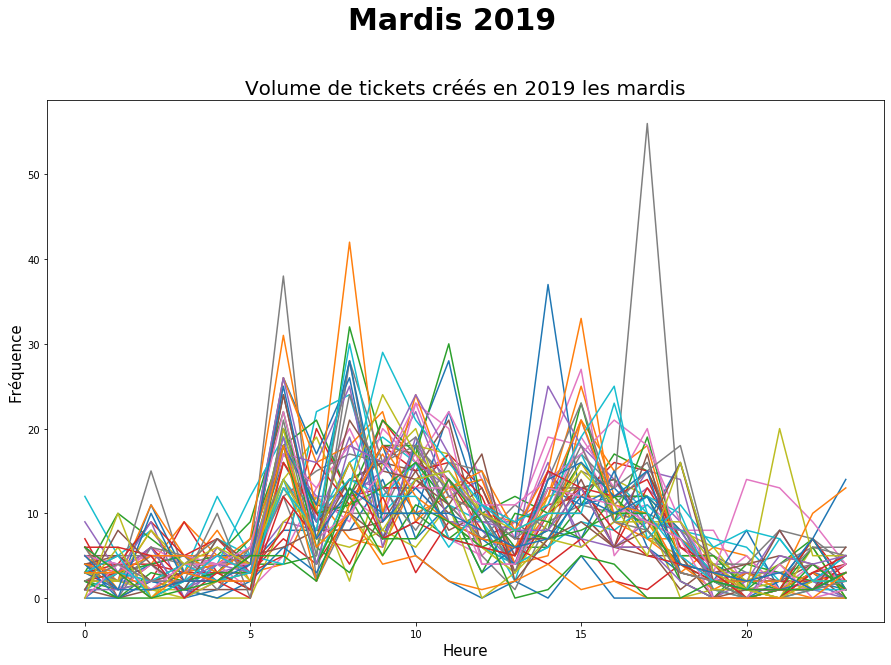

In [35]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
fig.suptitle('Mardis 2019', fontsize=30, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
#

#df_l.plot()
plt.plot(df_ma)

ax.set_title('Volume de tickets créés en 2019 les mardis', fontsize = 20)
ax.set_xlabel('Heure', fontsize = 15)
ax.set_ylabel('Fréquence', fontsize = 15)

#plt.legend()
plt.show()

## Mercredi 

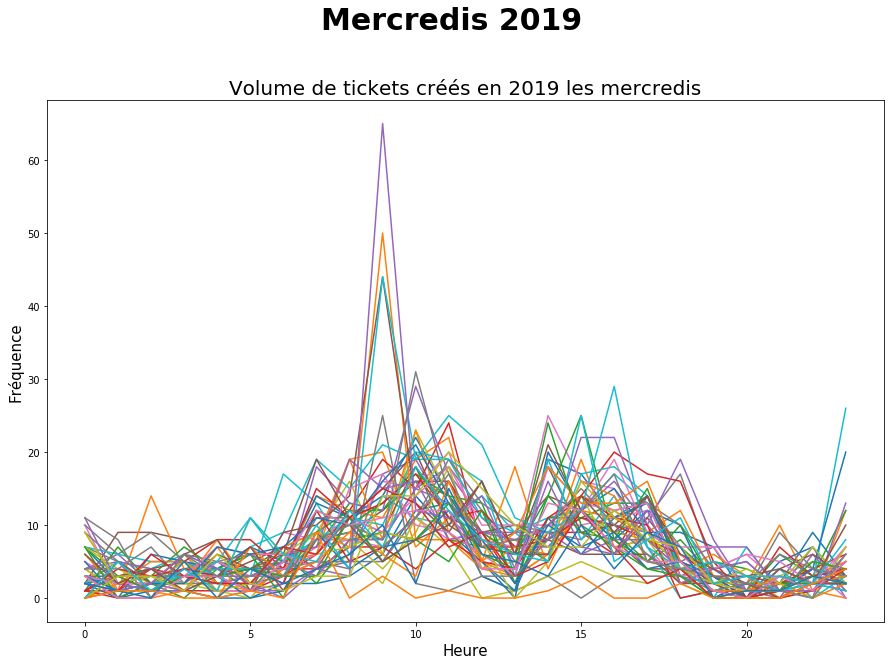

In [36]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
fig.suptitle('Mercredis 2019', fontsize=30, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
#

#df_l.plot()
plt.plot(df_me)

ax.set_title('Volume de tickets créés en 2019 les mercredis', fontsize = 20)
ax.set_xlabel('Heure', fontsize = 15)
ax.set_ylabel('Fréquence', fontsize = 15)

#plt.legend()
plt.show()

## Jeudi

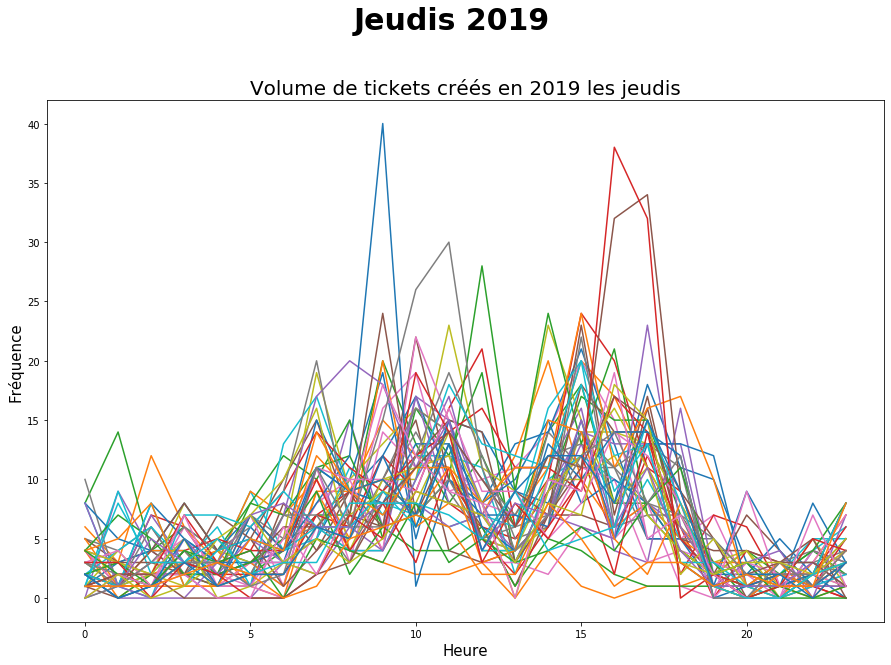

In [37]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
fig.suptitle('Jeudis 2019', fontsize=30, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
#

#df_l.plot()
plt.plot(df_j)

ax.set_title('Volume de tickets créés en 2019 les jeudis', fontsize = 20)
ax.set_xlabel('Heure', fontsize = 15)
ax.set_ylabel('Fréquence', fontsize = 15)

#plt.legend()
plt.show()

## Vendredi

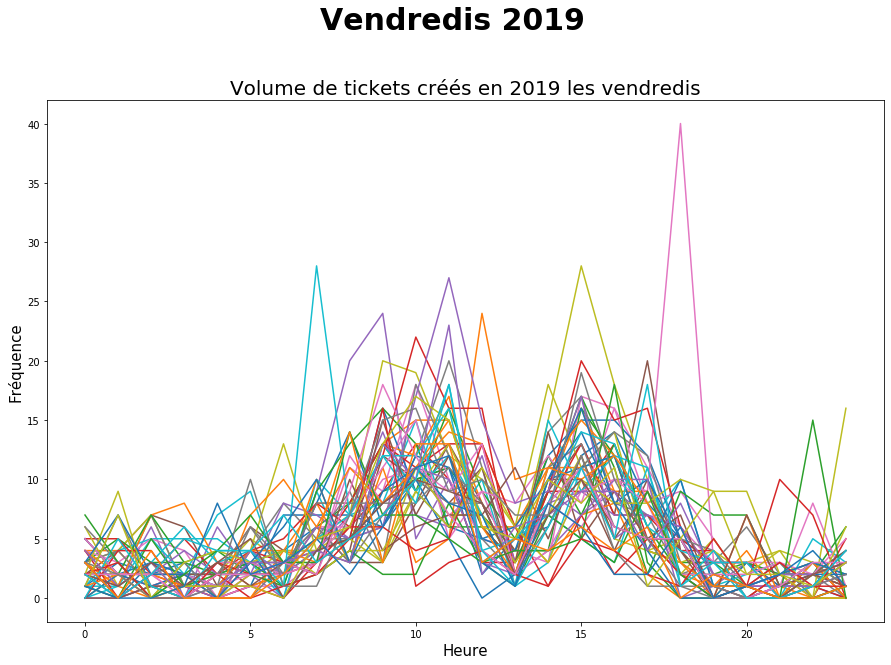

In [38]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
fig.suptitle('Vendredis 2019', fontsize=30, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
#

#df_l.plot()
plt.plot(df_v)

ax.set_title('Volume de tickets créés en 2019 les vendredis', fontsize = 20)
ax.set_xlabel('Heure', fontsize = 15)
ax.set_ylabel('Fréquence', fontsize = 15)

#plt.legend()
plt.show()

## Samedi

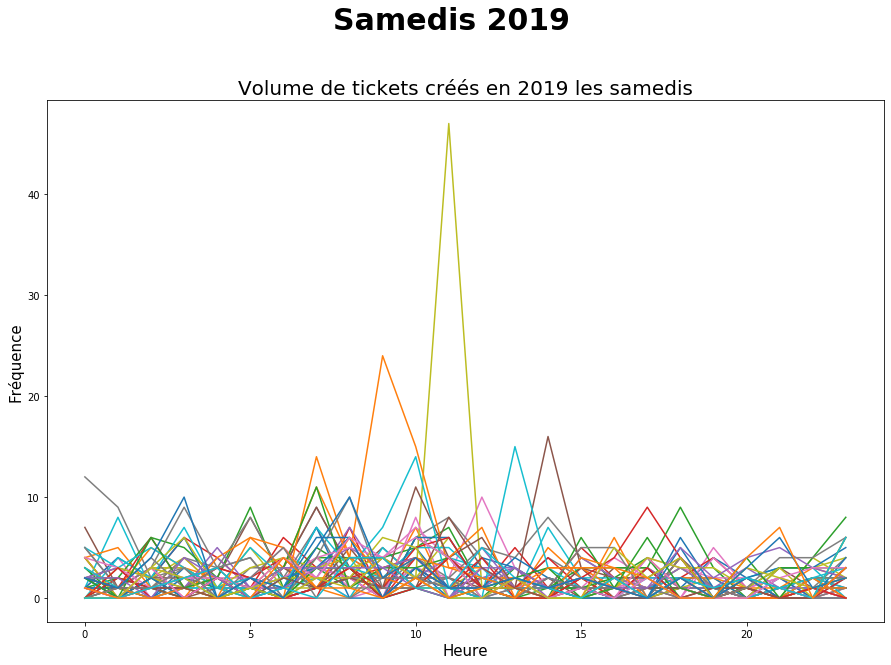

In [39]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
fig.suptitle('Samedis 2019', fontsize=30, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
#

#df_l.plot()
plt.plot(df_s)

ax.set_title('Volume de tickets créés en 2019 les samedis', fontsize = 20)
ax.set_xlabel('Heure', fontsize = 15)
ax.set_ylabel('Fréquence', fontsize = 15)

#plt.legend()
plt.show()

## Dimanche

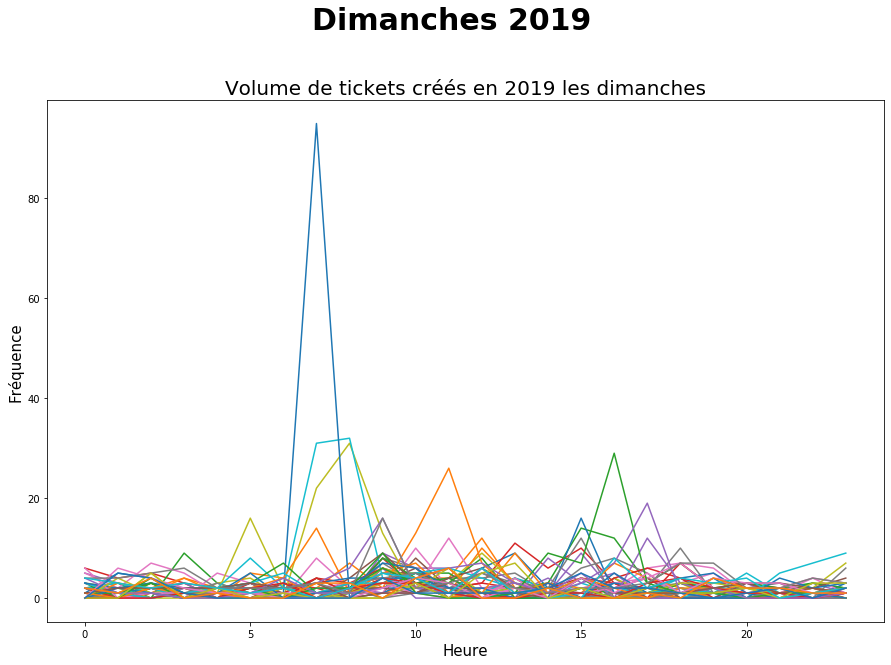

In [40]:
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15, 10))
fig.suptitle('Dimanches 2019', fontsize=30, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
#

#df_l.plot()
plt.plot(df_d)

ax.set_title('Volume de tickets créés en 2019 les dimanches', fontsize = 20)
ax.set_xlabel('Heure', fontsize = 15)
ax.set_ylabel('Fréquence', fontsize = 15)

#plt.legend()
plt.show()

---
# Sauvegarde des tables à utiliser pour la modélisation prédictive

In [41]:
tick_2019.to_csv('tick_2019.csv')
df_l.to_csv('data_lundi_2019.csv')
df_ma.to_csv('data_mardi_2019.csv')
df_me.to_csv('data_mercredi_2019.csv')
df_j.to_csv('data_jeudi_2019.csv')
df_v.to_csv('data_vendredi_2019.csv')
df_s.to_csv('data_samedi_2019.csv')
df_d.to_csv('data_dimanche_2019.csv')

In [70]:
supervision.to_csv('df_super.csv')

In [8]:
tickets.to_csv('df_tickets.csv')

In [107]:
df_result.to_csv('df_result.csv')

Prédiction de la survenue d'incident

In [72]:
tickets.head()

ID de la requete   Heure de creation Categorie   Priorite  \
0            280377 2015-06-11 18:22:00   Demande   3-Faible   
1            319699 2016-02-03 17:04:00  Probleme  2-Moyenne   
2            340448 2016-05-31 17:52:00   Demande  2-Moyenne   
3            342031 2016-06-07 18:24:00   Demande  2-Moyenne   
4            350047 2016-07-29 11:51:00   Demande   3-Faible   

                Groupe year_month  
0  Direction Technique    2015-06  
1                  SSE    2016-02  
2            Direction    2016-05  
3            Direction    2016-06  
4               EA PHP    2016-07

In [73]:
supervision.head()

ID  Severity  Status                Time         TimeCreated  \
0  AA24819711-06708         5  Closed 2020-02-08 04:22:17 2020-02-08 04:22:16   
1  AA24819711-08295         5  Closed 2020-02-08 04:27:26 2020-02-08 04:22:24   
2  AA24819711-50527         4  Closed 2020-02-08 04:26:41 2020-02-08 04:24:43   
3  AA24819711-84108         5  Closed 2020-02-08 04:27:17 2020-02-08 04:27:16   
4  AA24819711-85701         5  Closed 2020-02-08 04:32:23 2020-02-08 04:27:23   

                                             Message  Events  Count Subsystem  \
0  URL response for https://api.coreye.fr (COREYE...       1      1     Alarm   
1  The SNMP Agent at '10.60.16.156' is not respon...       1      1   Network   
2  Packet Loss is above threshold limit! (profile...       1      1   Network   
3  URL response for https://api.coreye.fr (COREYE...       1      1     Alarm   
4  N3064-FR-PAR2-B101B-02 miss .1.3.6.1.4.1.9.9.3...       1      1   Network   

           HostName            Source Origin          Robot        Probe  \
0     superviz-app1        10.31.65.1   PAR1  superviz-app1       logmon   
1      10.60.16.156      10.60.16.156   PAR1  superviz-app1      snmpget   
2  N5548-FR-PAR2-01  N5548-FR-PAR2-01   PAR1  superviz-app1  net_connect   
3     superviz-app1        10.31.65.1   PAR1  superviz-app1       logmon   
4      10.60.16.154      10.60.16.154   PAR1  superviz-app1      snmpget   

   Custom1 Visible  Duration_h  Heure   weekday  
0        0      No    0.000278      4  Saturday  
1        0      No    0.083889      4  Saturday  
2        0      No    0.032778      4  Saturday  
3        0      No    0.000278      4  Saturday  
4        0      No    0.083333      4  Saturday